In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel,RationalQuadratic
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


In [3]:
# read file
df = pd.read_csv("merged_booking_final.csv")

# comvert checkin to datetime
df["checkin"] = pd.to_datetime(df["checkin"])

# calculate snapshot date
snapshot_date = df["checkin"].min()

# calculate ttt
df["ttt"] = (df["checkin"] - snapshot_date).dt.days

# save the snapshot date
df.to_csv("merged_booking_final.csv", index=False)

df.head()

,hotel_name,star_rating,rating_score,location_score,review_amount,price,breakfast_included,free_cancellation,no_prepayment_needed,centrally_located,sustainability_certification,checkin,checkout,snapshot,group_index,bed_score,distance_score,hotel_name_encoded,ttt,los
0,Roxy Hotel New York,4.0,8.6,9.3,1145.0,398,0,0,0,1,0,2025-03-10,2025-03-11,2025-03-10,1,4.0,5,280,0,1
1,Riu Plaza Manhattan Times Square,4.0,8.7,9.6,13232.0,275,0,0,1,1,1,2025-03-10,2025-03-11,2025-03-10,2,4.0,5,276,0,1
2,UNTITLED at 3 Freeman Alley,4.0,8.5,NaN,592.0,243,0,0,0,1,0,2025-03-10,2025-03-11,2025-03-10,3,3.0,5,390,0,1
3,Aura Hotel Times Square Newly Renovated,4.0,7.7,9.4,507.0,259,0,0,0,1,0,2025-03-10,2025-03-11,2025-03-10,4,2.0,5,27,0,1
4,Sonder at One Platt,4.0,8.2,NaN,1908.0,220,0,0,0,1,0,2025-03-10,2025-03-11,2025-03-10,5,0.0,5,302,0,1


In [4]:
# check missing values
print("Missing in star_rating:", df["star_rating"].isna().sum())

Missing in star_rating: 389


## Feature Engineering
### calculating new features(based on existing ones):
- Day of the week - extracting the exact day of the week from check-in date.
- is weekend - checking if the given check-in date is in weekend.
- days to month end - checking distance between check-in day to end of current month.
- Short notice - checking if TTT is lower then 14 what means checked for hotels in less then two weeks prior.
- check in month+year for seasonality demand.
- check in day - checks specific day of month to check pricing patterns.

In [5]:
# Feature Engineering

# Extract day of week from check-in date
df['day_of_week'] = pd.to_datetime(df['checkin']).dt.dayofweek

# Create a feature for weekend check-ins
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Distance from end of month
df['days_to_month_end'] = pd.to_datetime(df['checkin']).dt.days_in_month - pd.to_datetime(df['checkin']).dt.day

# Short notice booking flag
df['short_notice'] = (df['ttt'] < 14).astype(int)


# Extract month and year for seasonality
df['check_in_month'] = pd.to_datetime(df['checkin']).dt.month
df['check_in_year'] = pd.to_datetime(df['checkin']).dt.year

# Extract day of month to capture pricing patterns
df['check_in_day'] = pd.to_datetime(df['checkin']).dt.day

# Check the engineered features
print("\nAfter feature engineering:")
print(df.head())


After feature engineering:
                                hotel_name  star_rating  rating_score  \
0                      Roxy Hotel New York          4.0           8.6   
1         Riu Plaza Manhattan Times Square          4.0           8.7   
2              UNTITLED at 3 Freeman Alley          4.0           8.5   
3  Aura Hotel Times Square Newly Renovated          4.0           7.7   
4                      Sonder at One Platt          4.0           8.2   

   location_score  review_amount  price  breakfast_included  \
0             9.3         1145.0    398                   0   
1             9.6        13232.0    275                   0   
2             NaN          592.0    243                   0   
3             9.4          507.0    259                   0   
4             NaN         1908.0    220                   0   

   free_cancellation  no_prepayment_needed  centrally_located  ...  \
0                  0                     0                  1  ...   
1             

In [6]:
# Drop unnecessary columns
drop_cols = [
    "price",
    "hotel_name",      # טקסט שאין בו צורך מודלי
    "price",           # הגרסה הגולמית
    "checkin", "checkout",
    "snapshot",
    "group_index"
]

# check if columns exist
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols, errors="ignore")
y = df["price"]
X = X.fillna(-1)


In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (31780, 21)
Test set size: (13620, 21)


## Data normalization, scalling and evaluation function

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler_standard = StandardScaler()
X_train_std = scaler_standard.fit_transform(X_train)
X_test_std = scaler_standard.transform(X_test)


scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)


scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

# Evaluation Metrics and Residual Plots
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model", scaler_name=""):
    # Train and predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    scaling_info = f" with {scaler_name}" if scaler_name else ""
    print(f"\n{model_name}{scaling_info} Performance:")
    print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    
    # Plot residuals
    plt.figure(figsize=(12, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    residuals_train = y_train - y_train_pred
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Training Residuals')
    
    # Test residuals
    plt.subplot(1, 2, 2)
    residuals_test = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Test Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Training Residuals Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Test Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }


# Regression models


--- Linear Regression ---

Linear Regression with StandardScaler Performance:
Train MSE: 161312.05, Test MSE: 258794.73
Train RMSE: 401.64, Test RMSE: 508.72
Train MAE: 235.37, Test MAE: 237.88
Train R²: 0.6594, Test R²: 0.5464


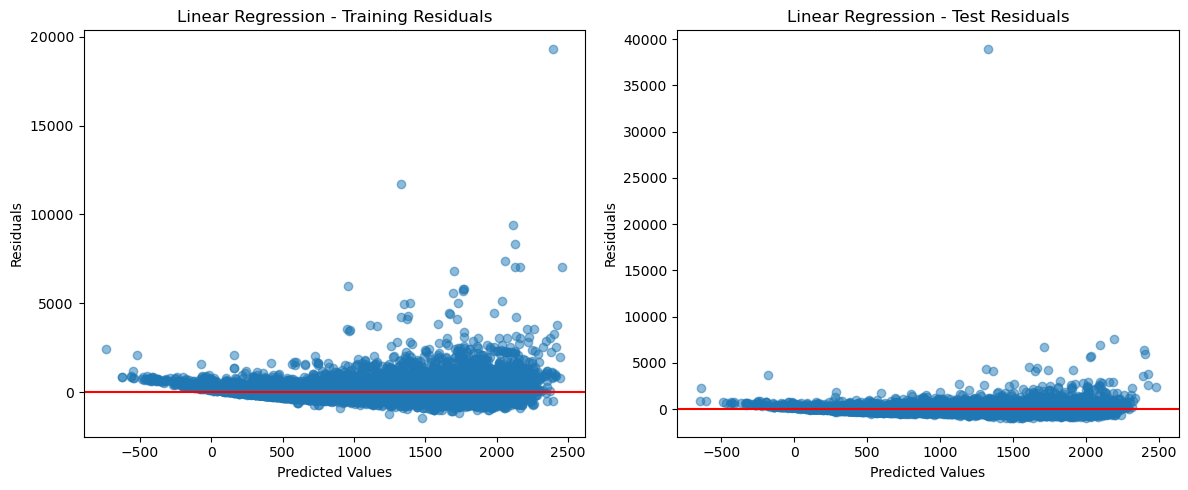

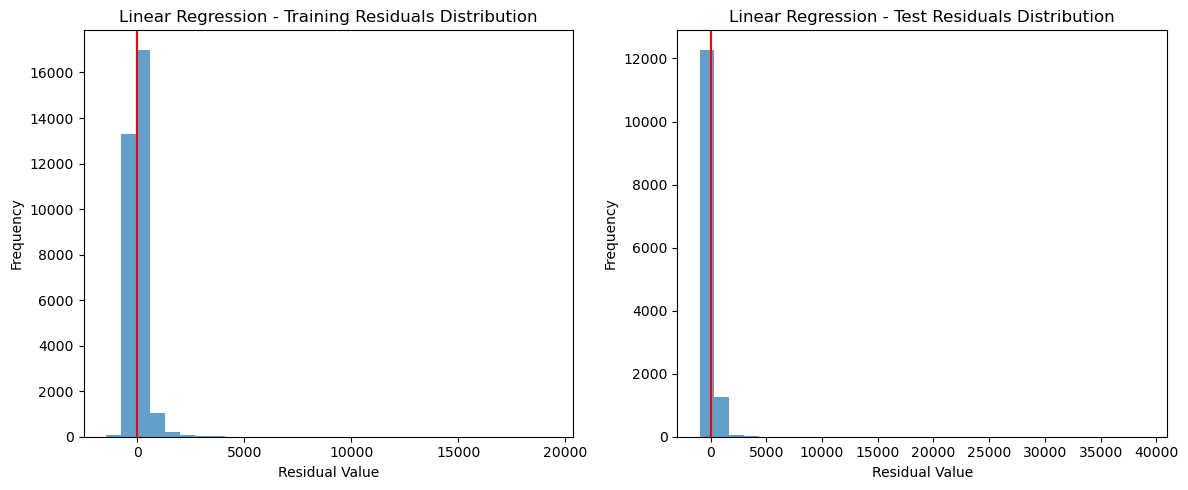


Linear Regression with MinMaxScaler Performance:
Train MSE: 161306.14, Test MSE: 258783.52
Train RMSE: 401.63, Test RMSE: 508.71
Train MAE: 235.29, Test MAE: 237.77
Train R²: 0.6595, Test R²: 0.5464


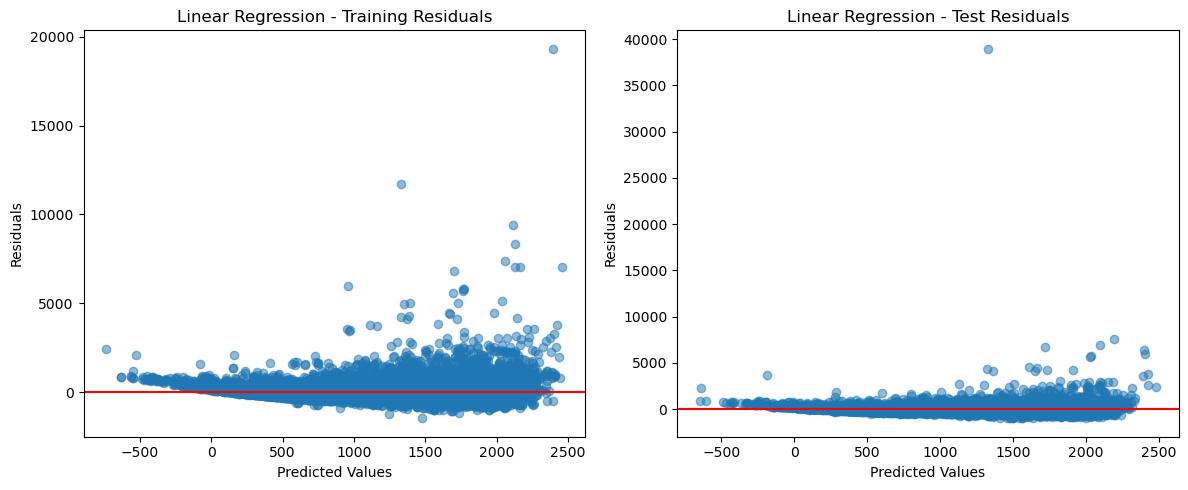

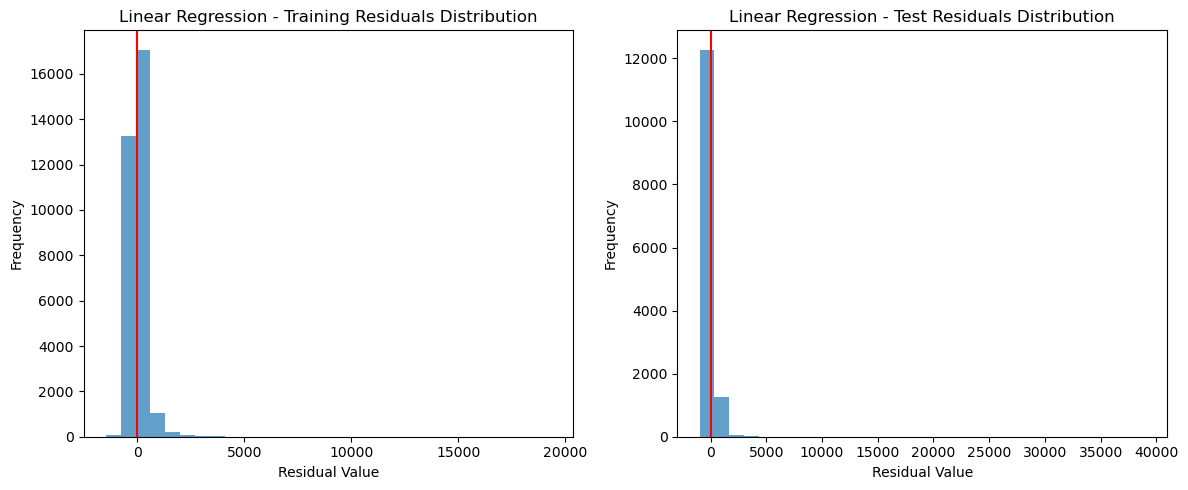


--- Decision Tree Regressor ---

Decision Tree Regressor Performance:
Train MSE: 127230.39, Test MSE: 251068.67
Train RMSE: 356.69, Test RMSE: 501.07
Train MAE: 218.56, Test MAE: 225.20
Train R²: 0.7314, Test R²: 0.5599


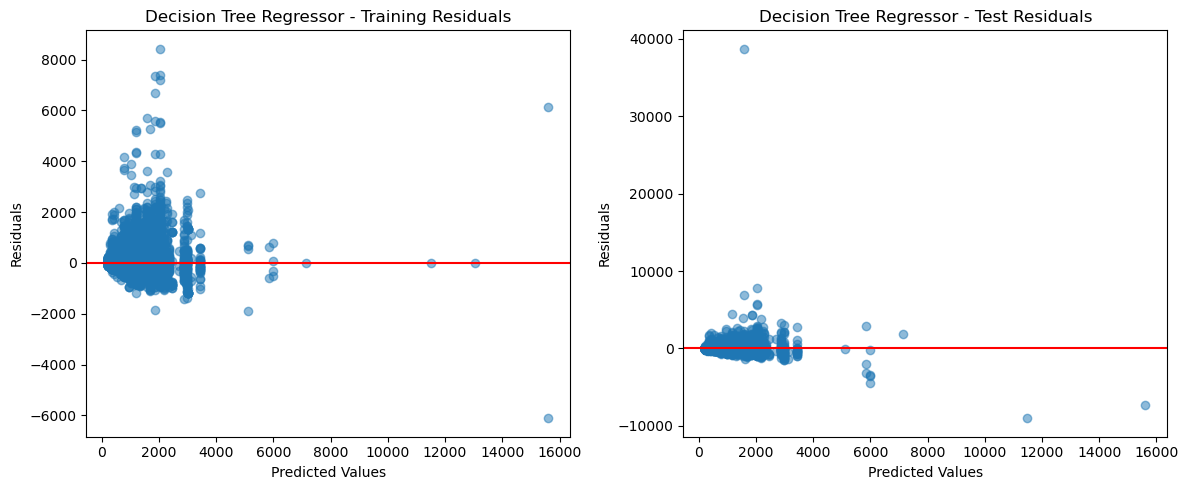

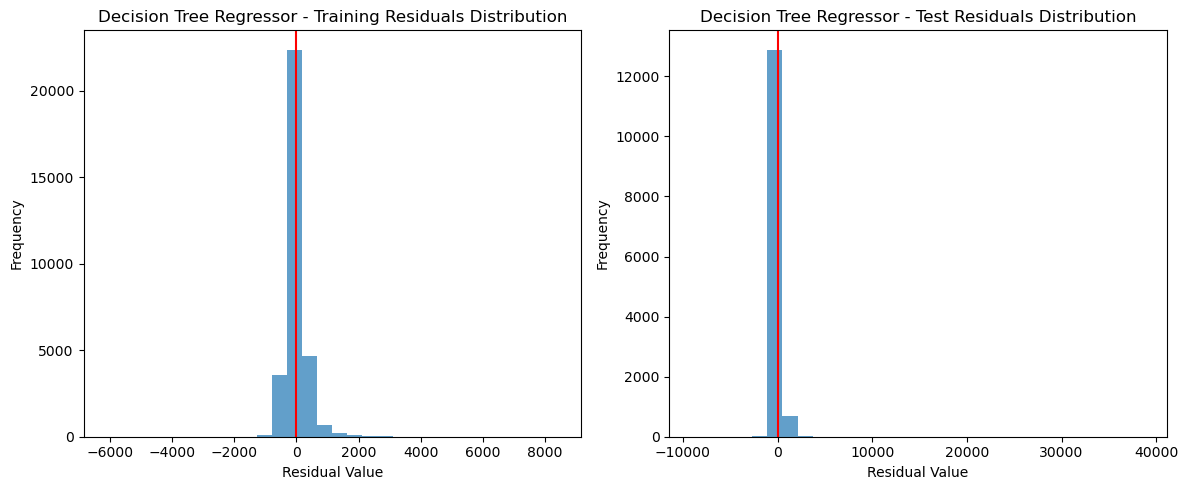

Best parameters: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 5}

--- Gaussian Process Regressor (Improved) ---

Testing GPR with RBF kernel

Gaussian Process Regressor (RBF) Performance:
Train MSE: 0.00, Test MSE: 381734.56
Train RMSE: 0.00, Test RMSE: 617.85
Train MAE: 0.00, Test MAE: 503.92
Train R²: 1.0000, Test R²: 0.0054


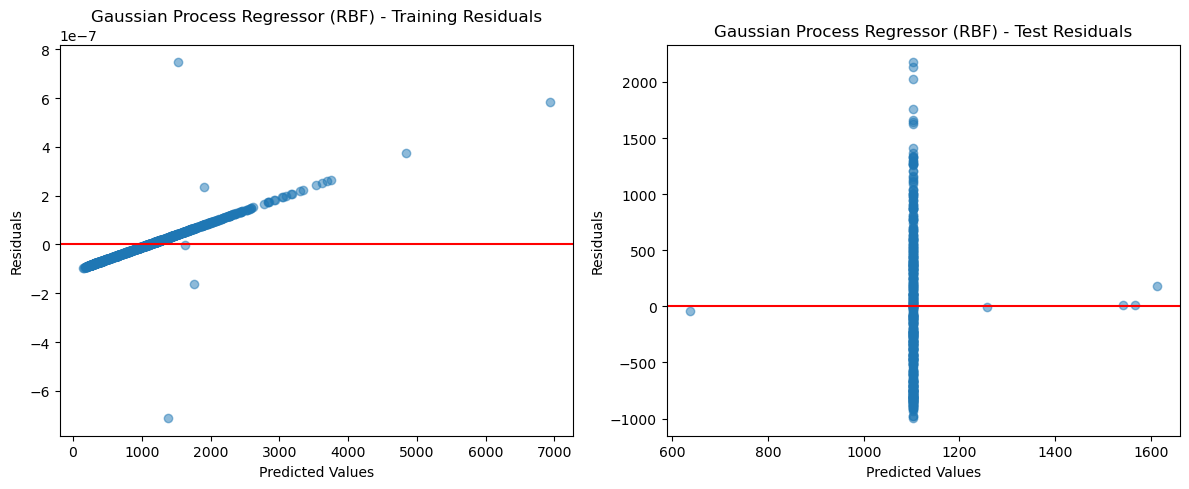

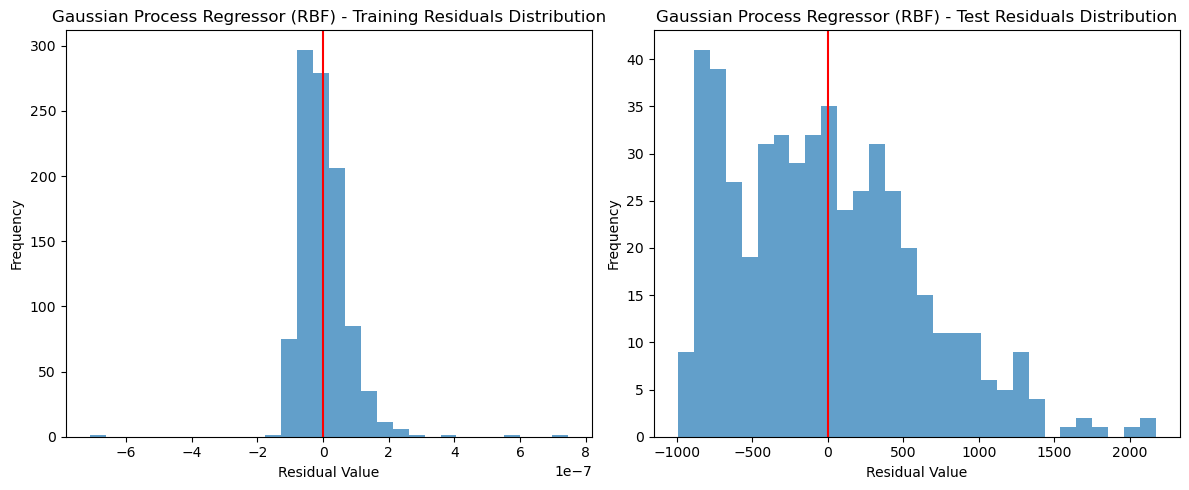


Testing GPR with RBF+White kernel

Gaussian Process Regressor (RBF+White) Performance:
Train MSE: 60126.91, Test MSE: 74648.00
Train RMSE: 245.21, Test RMSE: 273.22
Train MAE: 162.89, Test MAE: 191.52
Train R²: 0.8669, Test R²: 0.8055


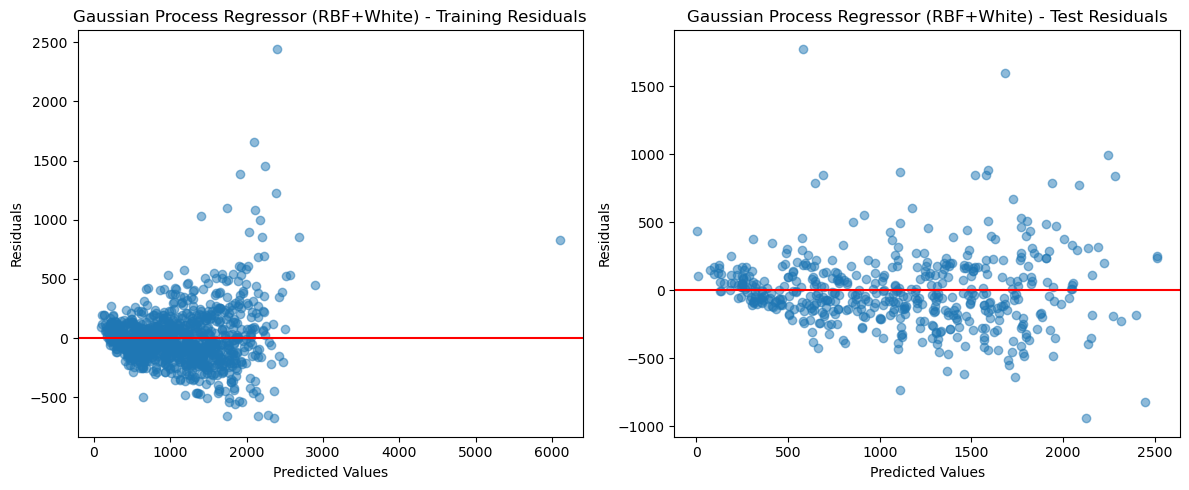

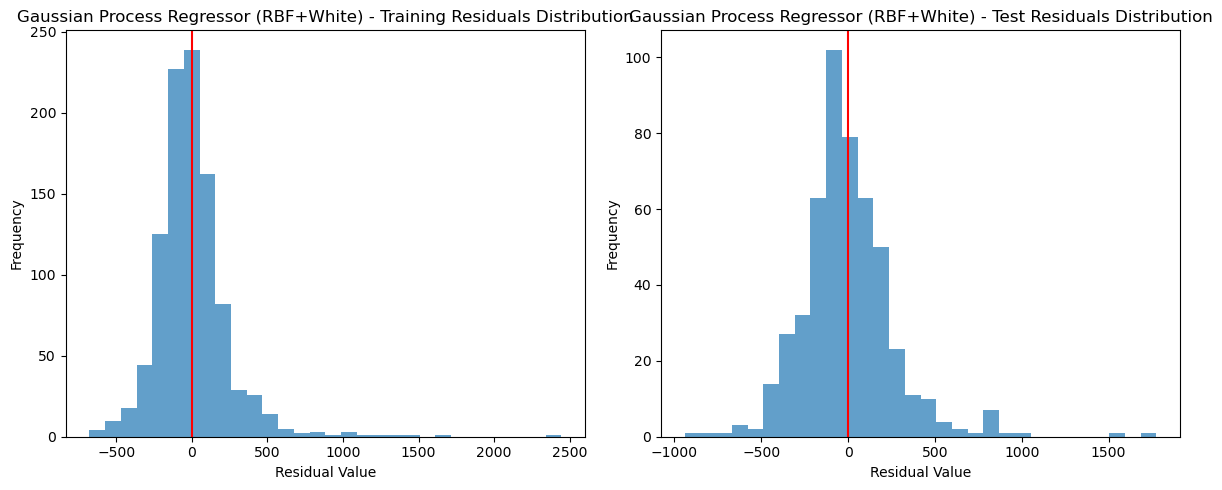


Testing GPR with RationalQuadratic kernel

Gaussian Process Regressor (RationalQuadratic) Performance:
Train MSE: 0.00, Test MSE: 101968.47
Train RMSE: 0.00, Test RMSE: 319.33
Train MAE: 0.00, Test MAE: 233.61
Train R²: 1.0000, Test R²: 0.7343


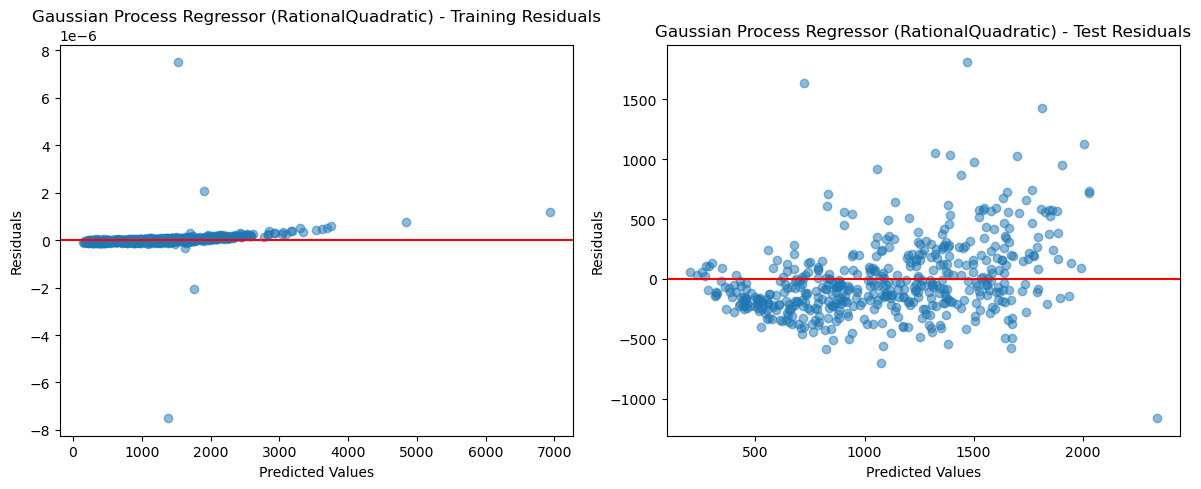

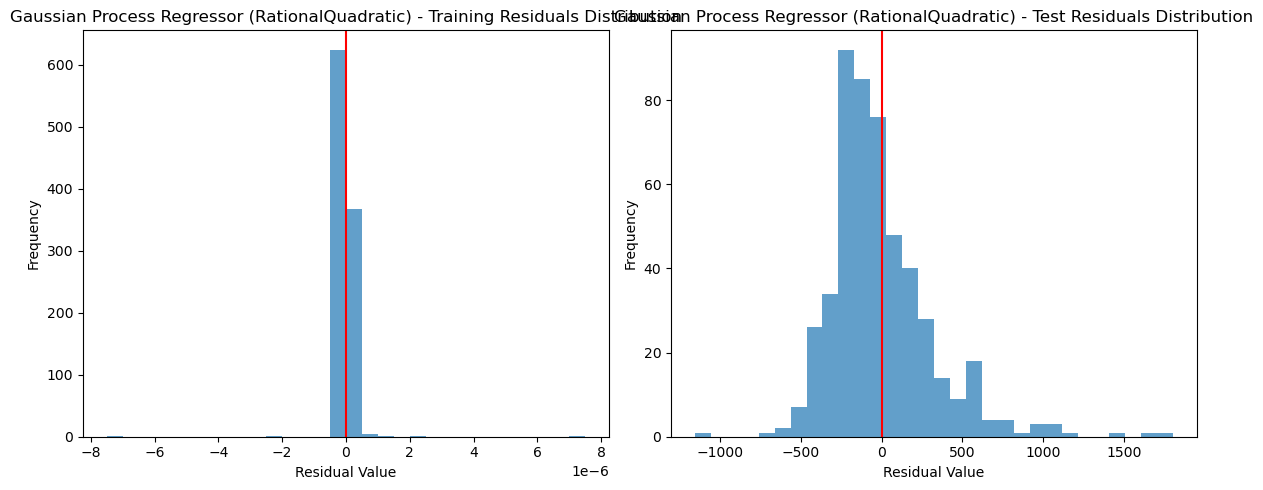


Best GPR kernel: RBF+White with R² score: 0.8055

--- Random Forest Regressor ---

Random Forest (GridSearch) Performance:
Train MSE: 183833.88, Test MSE: 282259.52
Train RMSE: 428.76, Test RMSE: 531.28
Train MAE: 256.69, Test MAE: 261.09
Train R²: 0.6119, Test R²: 0.5053


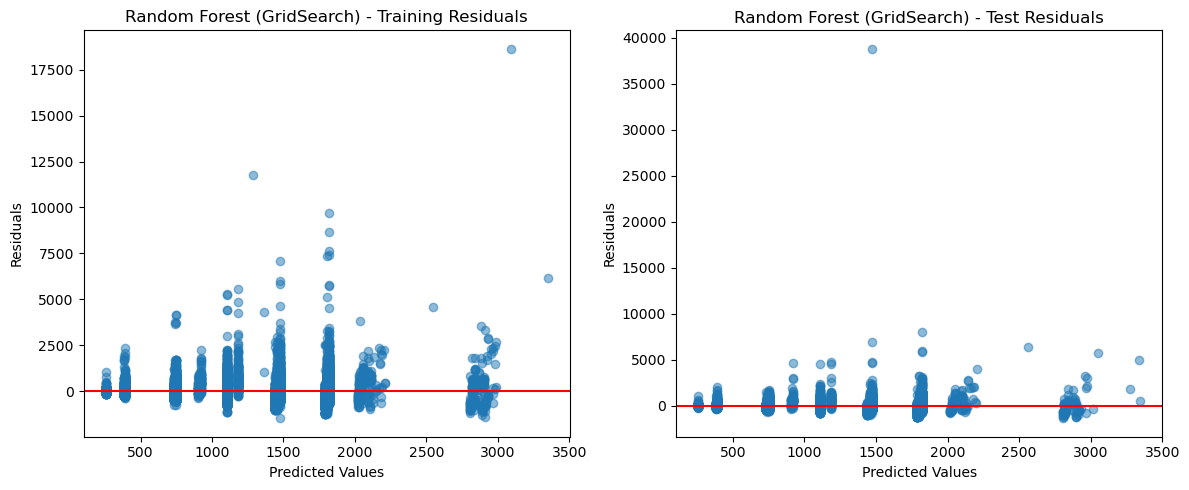

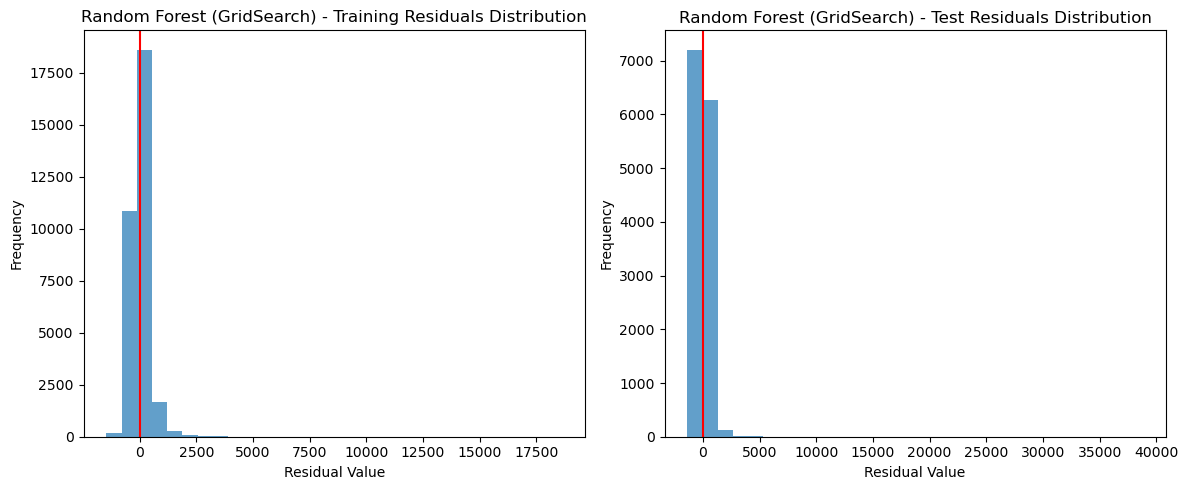

Best RF parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}

--- Gradient Boosting Regressor ---

Gradient Boosting Regressor Performance:
Train MSE: 84854.56, Test MSE: 191948.01
Train RMSE: 291.30, Test RMSE: 438.12
Train MAE: 162.45, Test MAE: 166.46
Train R²: 0.8209, Test R²: 0.6636


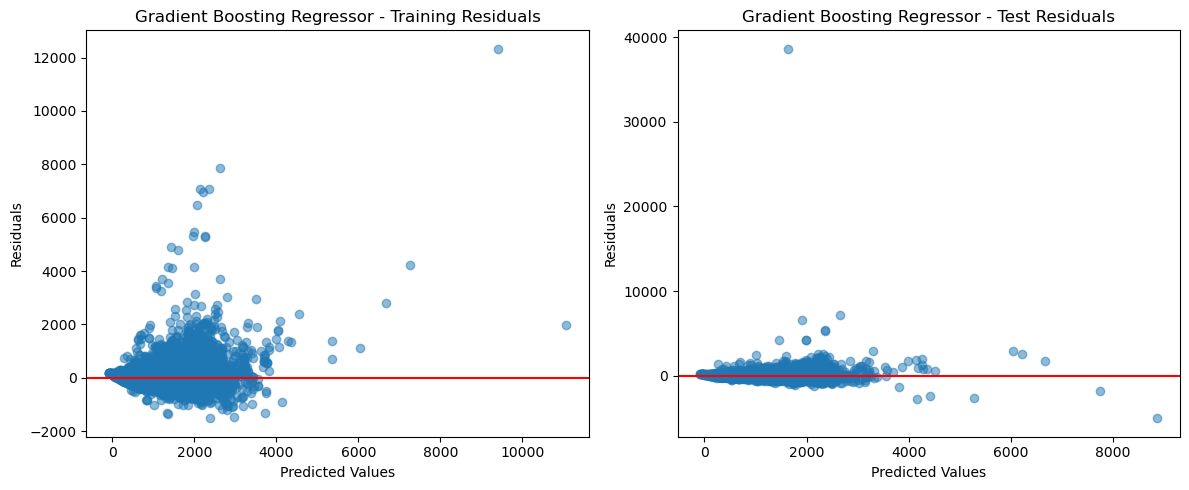

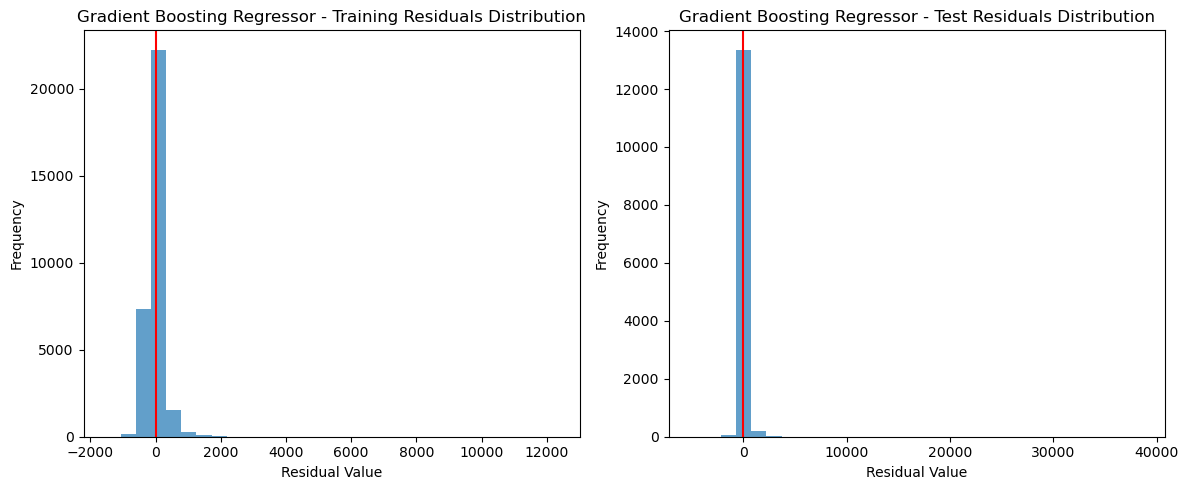


--- Support Vector Regression ---

SVR with linear kernel:

SVR (linear) Performance:
Train MSE: 174432.00, Test MSE: 123847.83
Train RMSE: 417.65, Test RMSE: 351.92
Train MAE: 232.56, Test MAE: 214.72
Train R²: 0.6307, Test R²: 0.6828


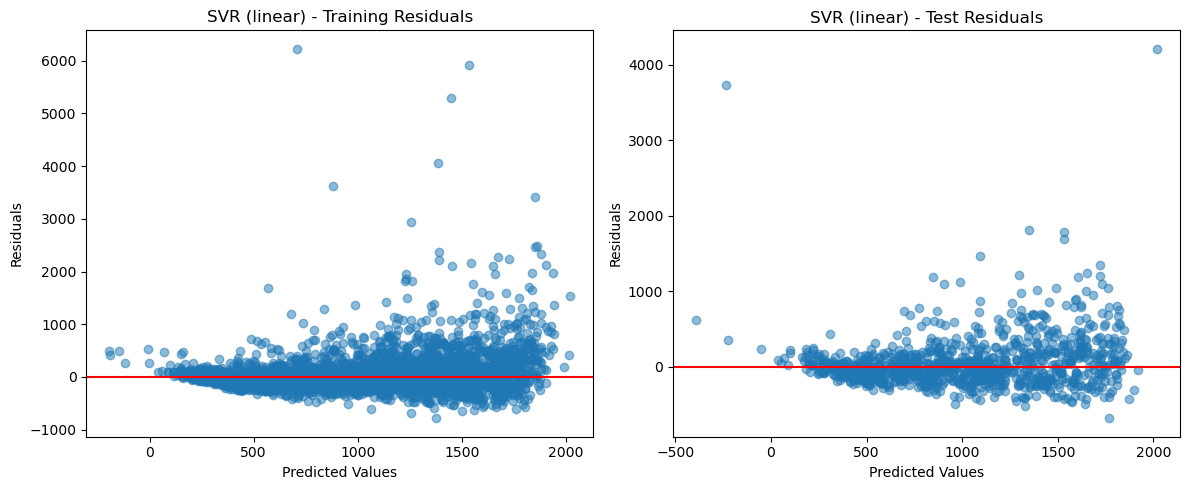

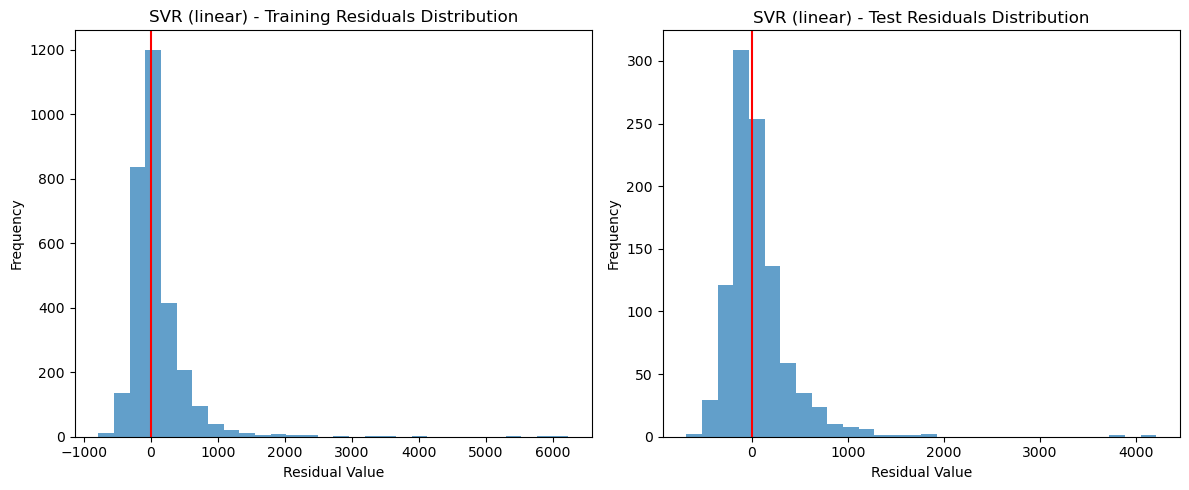


SVR with poly kernel:

SVR (poly) Performance:
Train MSE: 437975.35, Test MSE: 358287.45
Train RMSE: 661.80, Test RMSE: 598.57
Train MAE: 496.29, Test MAE: 468.31
Train R²: 0.0726, Test R²: 0.0823


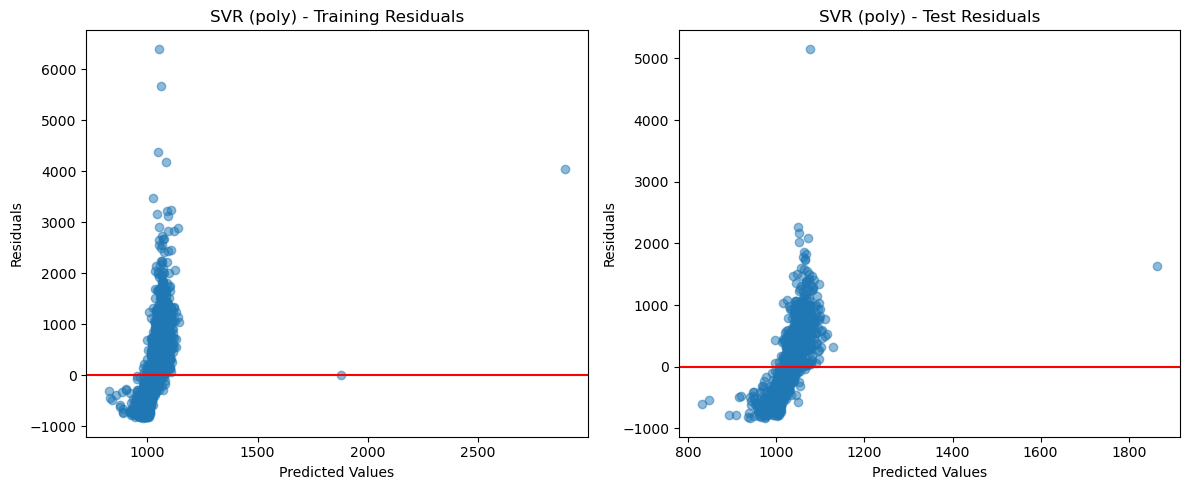

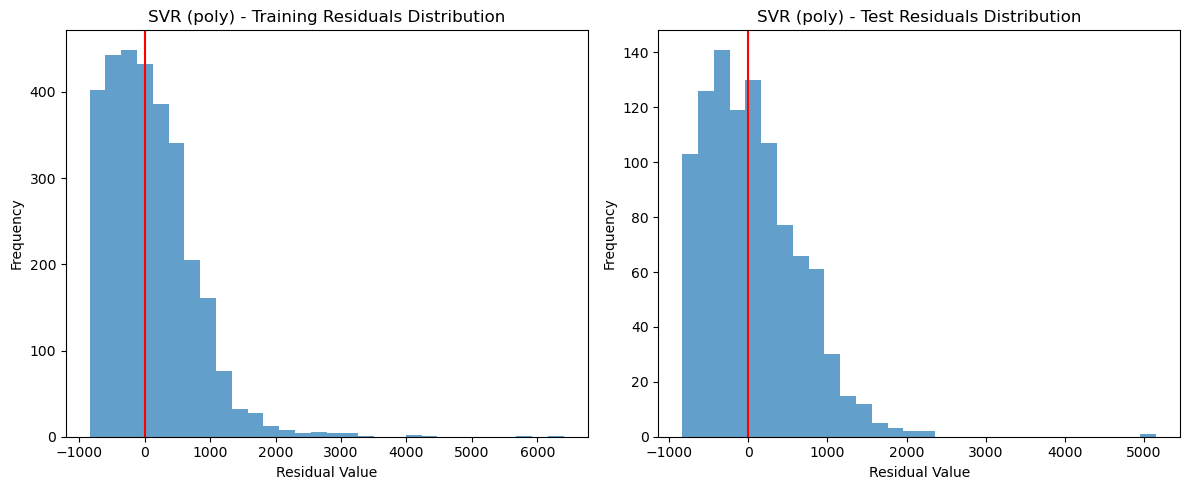


SVR with rbf kernel:

SVR (rbf) Performance:
Train MSE: 435037.30, Test MSE: 352726.81
Train RMSE: 659.57, Test RMSE: 593.91
Train MAE: 489.85, Test MAE: 462.13
Train R²: 0.0789, Test R²: 0.0966


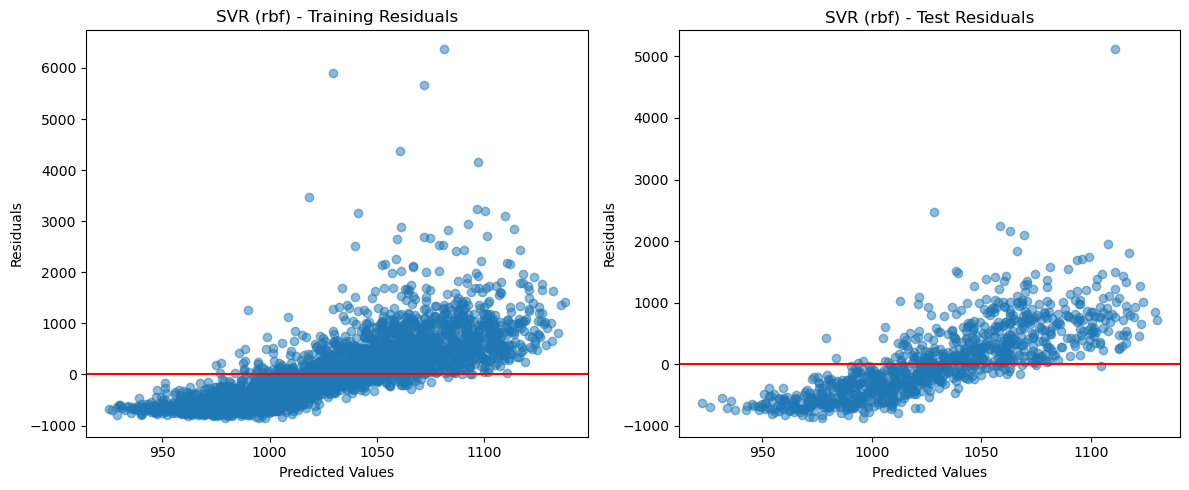

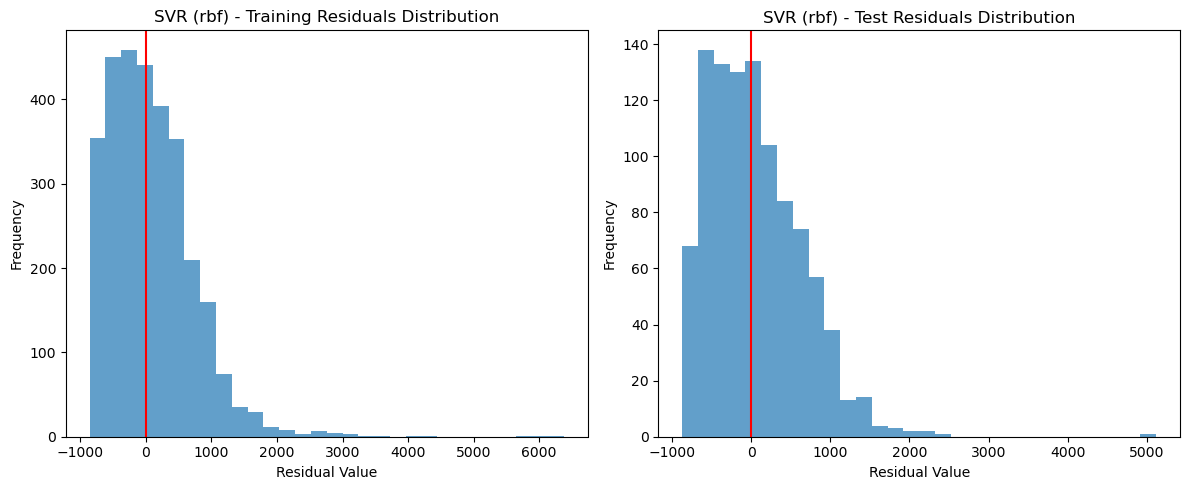


 Models comparison:
  1. Linear Regression (Standard)
  2. Linear Regression (MinMax)
  3. Decision Tree
  4. Gaussian Process (RBF+White)
  5. Random Forest
  6. Gradient Boosting
  7. SVR

=== Model Performance Comparison ===
                       Model       R²        MAE           MSE       RMSE
Gaussian Process (RBF+White) 0.805510        NaN           NaN        NaN
           Gradient Boosting 0.663552 166.455320 191948.008110 438.118715
               Decision Tree 0.559925 225.200467 251068.669764 501.067530
  Linear Regression (MinMax) 0.546402 237.774229 258783.515932 508.707692
Linear Regression (Standard) 0.546383 237.876593 258794.730651 508.718715
               Random Forest 0.505253 261.093597 282259.523420 531.281021
                         SVR 0.096567 462.134333 352726.809274 593.908082


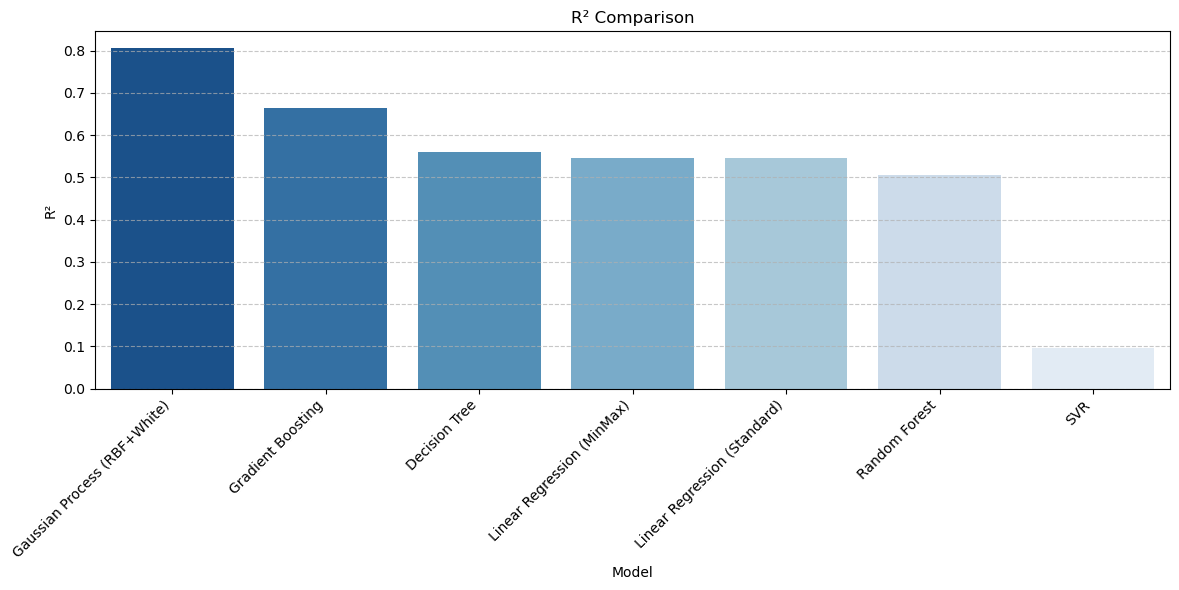

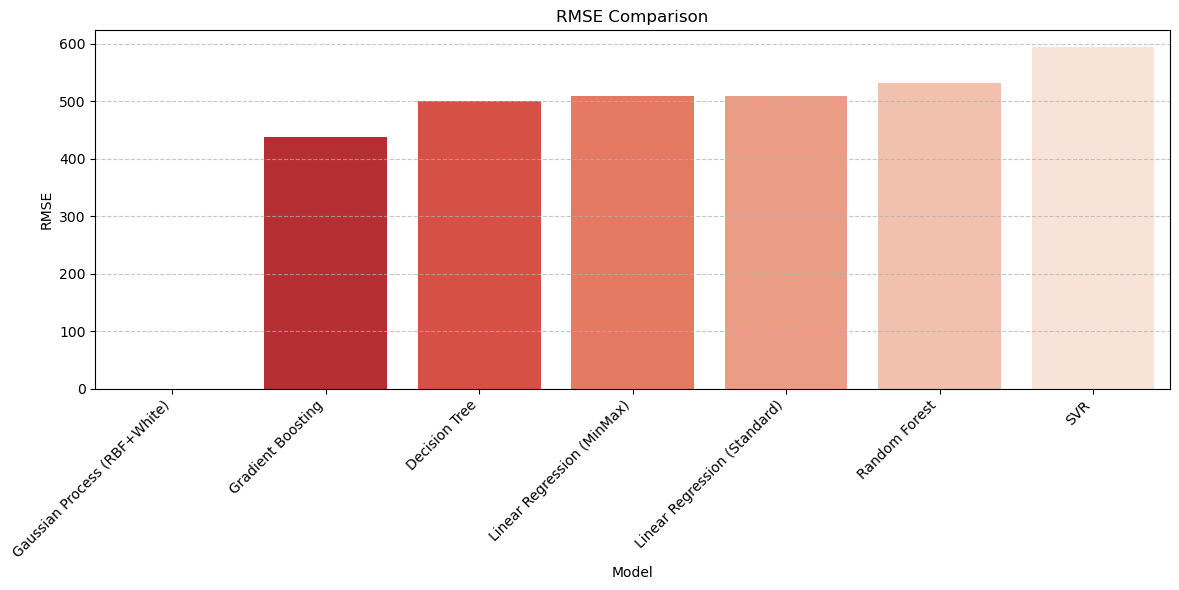

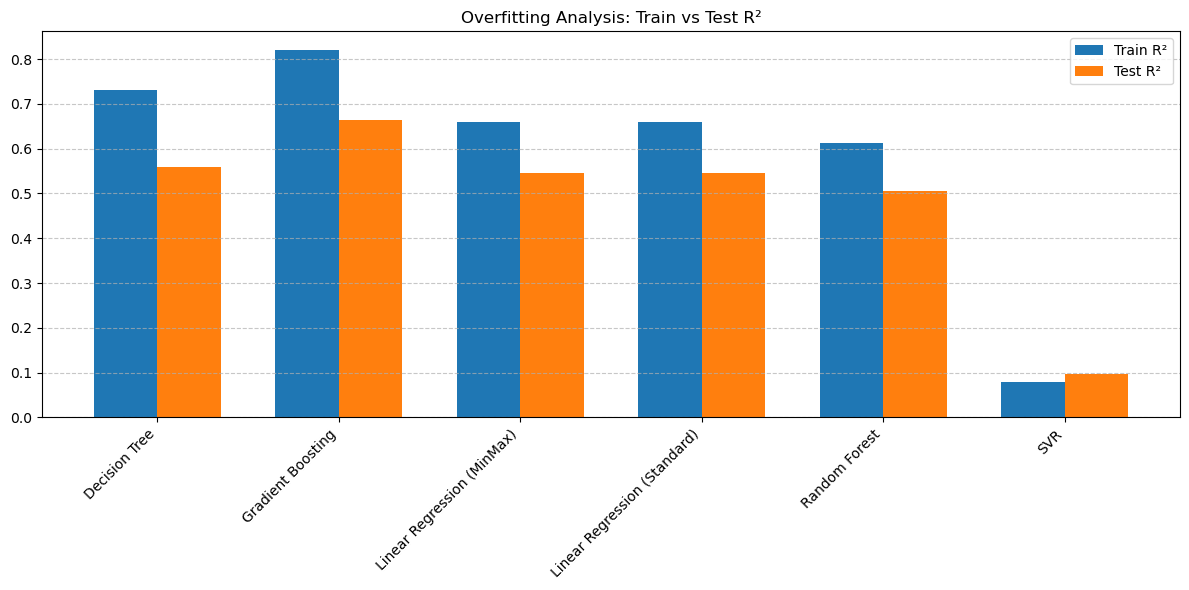

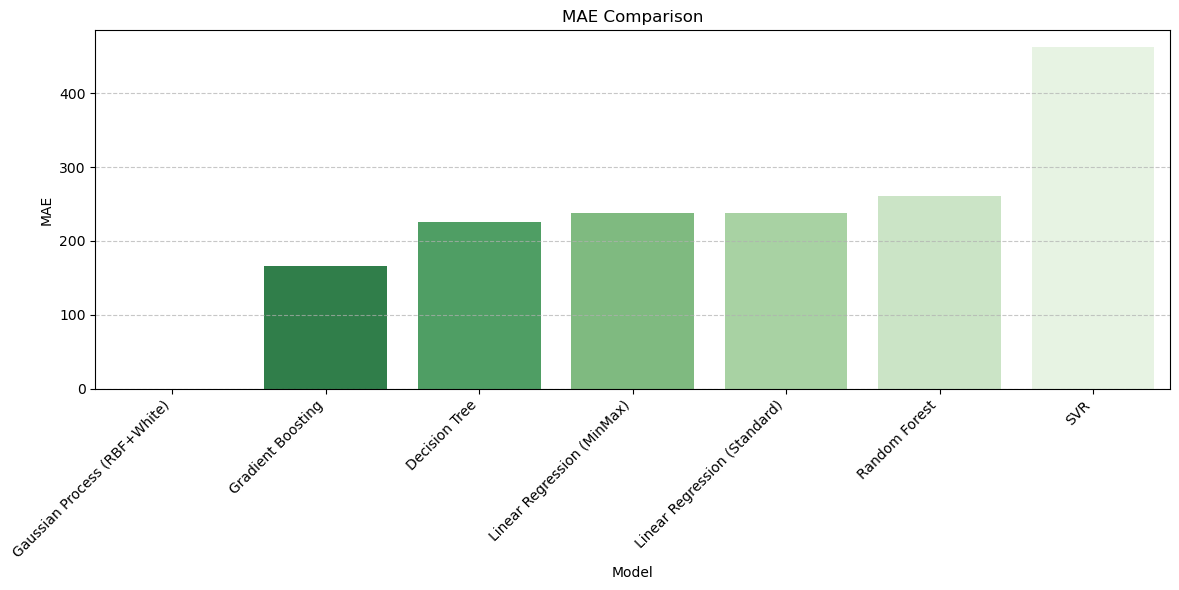


=== Best Performing Model ===
Model: Gaussian Process (RBF+White)
R² Score: 0.8055
RMSE: nan
MAE: nan


,Model,R²,MAE,MSE,RMSE,Train R²,Overfitting
3,Gaussian Process (RBF+White),0.805510,NaN,NaN,NaN,NaN,NaN
5,Gradient Boosting,0.663552,166.455320,191948.008110,438.118715,0.820857,0.157305
2,Decision Tree,0.559925,225.200467,251068.669764,501.067530,0.731394,0.171469
1,Linear Regression (MinMax),0.546402,237.774229,258783.515932,508.707692,0.659454,0.113052
0,Linear Regression (Standard),0.546383,237.876593,258794.730651,508.718715,0.659442,0.113059
4,Random Forest,0.505253,261.093597,282259.523420,531.281021,0.611894,0.106641
6,SVR,0.096567,462.134333,352726.809274,593.908082,0.078852,-0.017715


In [9]:
# Linear Regression
print("\n--- Linear Regression ---")
lr_model = LinearRegression()
lr_results_std = evaluate_model(lr_model, X_train_std, X_test_std, y_train, y_test, 
                               "Linear Regression", "StandardScaler")

# Try with different scaling methods to compare
lr_model_minmax = LinearRegression()
lr_results_minmax = evaluate_model(lr_model_minmax, X_train_minmax, X_test_minmax, y_train, y_test, 
                                  "Linear Regression", "MinMaxScaler")

# Decision Tree Regressor with different parameters
print("\n--- Decision Tree Regressor ---")
dt_params = {
    'max_depth': [3 ,6], 
    'min_samples_split': [2,5],
    'criterion': ['squared_error']
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=3, scoring='neg_mean_squared_error')
dt_results = evaluate_model(dt_grid, X_train, X_test, y_train, y_test, "Decision Tree Regressor")
print(f"Best parameters: {dt_grid.best_params_}")

# Gaussian Process Regressor
print("\n--- Gaussian Process Regressor (Improved) ---")

# Use stratified sampling for better representation (if possible)
sample_size = min(1000, len(X_train))
test_sample_size = min(500, len(X_test))

# Create a smaller sample for GPR
np.random.seed(42)
train_indices = np.random.choice(len(X_train_std), sample_size, replace=False)
test_indices = np.random.choice(len(X_test_std), test_sample_size, replace=False)

X_train_sample = X_train_std[train_indices]
y_train_sample = y_train.iloc[train_indices]
X_test_sample = X_test_std[test_indices]
y_test_sample = y_test.iloc[test_indices]

#kernel configurations
kernels = [
    ("RBF", RBF(length_scale=1.0)),
    ("RBF+White", RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)),  # Reduced noise
    ("RationalQuadratic", RationalQuadratic(alpha=1.0))
]

best_gpr_score = float('-inf')
best_gpr_model = None
best_gpr_kernel_name = ""

for kernel_name, kernel in kernels:
    print(f"\nTesting GPR with {kernel_name} kernel")
    # Add normalize_y=True to handle scale issues
    gpr_model = GaussianProcessRegressor(
        kernel=kernel, 
        n_restarts_optimizer=5, 
        normalize_y=True,  
        random_state=42
    )
    
    try:
        gpr_results = evaluate_model(gpr_model, X_train_sample, X_test_sample, 
                                    y_train_sample, y_test_sample, 
                                    f"Gaussian Process Regressor ({kernel_name})")
        
        # Track the best GPR model
        if gpr_results['test_r2'] > best_gpr_score:
            best_gpr_score = gpr_results['test_r2']
            best_gpr_model = gpr_model
            best_gpr_kernel_name = kernel_name
            
    except Exception as e:
        print(f"Error with {kernel_name} kernel: {e}")

print(f"\nBest GPR kernel: {best_gpr_kernel_name} with R² score: {best_gpr_score:.4f}")

# Random Forest Regressor


print("\n--- Random Forest Regressor ---")

# Quick grid search for Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, 
                      scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_results = evaluate_model(rf_grid, X_train, X_test, y_train, y_test, "Random Forest (GridSearch)")
print(f"Best RF parameters: {rf_grid.best_params_}")

# Gradient Boosting Regressor
print("\n--- Gradient Boosting Regressor ---")

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting Regressor")

# Support Vector Regression
print("\n--- Support Vector Regression ---")

# Sample the data for SVR - it can be slow on large datasets
sample_size_svr = min(3000, len(X_train))
test_sample_size_svr = min(1000, len(X_test))

# Create a smaller sample for SVR
X_train_sample_svr = X_train_std[:sample_size_svr]
y_train_sample_svr = y_train.iloc[:sample_size_svr]
X_test_sample_svr = X_test_std[:test_sample_size_svr]
y_test_sample_svr = y_test.iloc[:test_sample_size_svr]

# Try different kernels for SVR
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    print(f"\nSVR with {kernel} kernel:")
    svr_model = SVR(kernel=kernel, C=1.0, epsilon=0.1)
    try:
        svr_kernel_results = evaluate_model(
            svr_model, 
            X_train_sample_svr, 
            X_test_sample_svr, 
            y_train_sample_svr, 
            y_test_sample_svr,
            f"SVR ({kernel})"
        )
    except Exception as e:
        print(f"Error with SVR {kernel} kernel: {e}")


def compare_models(): 
    # Get all variables from global scope
    globals_dict = globals()
    
    # Initialize results list
    results = []
    
    # Track models found for reporting
    models_found = []
    
    # 1. LINEAR REGRESSION
    try:
        if 'lr_results_std' in globals_dict:
            results.append({
                'Model': 'Linear Regression (Standard)',
                'R²': globals_dict['lr_results_std']['test_r2'],
                'MAE': globals_dict['lr_results_std']['test_mae'],
                'MSE': globals_dict['lr_results_std']['test_mse'],
                'RMSE': globals_dict['lr_results_std']['test_rmse'],
                'Train R²': globals_dict['lr_results_std']['train_r2']
            })
            models_found.append("Linear Regression (Standard)")
        
        if 'lr_results_minmax' in globals_dict:
            results.append({
                'Model': 'Linear Regression (MinMax)',
                'R²': globals_dict['lr_results_minmax']['test_r2'],
                'MAE': globals_dict['lr_results_minmax']['test_mae'],
                'MSE': globals_dict['lr_results_minmax']['test_mse'],
                'RMSE': globals_dict['lr_results_minmax']['test_rmse'],
                'Train R²': globals_dict['lr_results_minmax']['train_r2']
            })
            models_found.append("Linear Regression (MinMax)")
    except Exception as e:
        print(f"Error adding Linear Regression models: {e}")
    
    # 2. DECISION TREE
    try:
        if 'dt_results' in globals_dict:
            results.append({
                'Model': 'Decision Tree',
                'R²': globals_dict['dt_results']['test_r2'],
                'MAE': globals_dict['dt_results']['test_mae'],
                'MSE': globals_dict['dt_results']['test_mse'],
                'RMSE': globals_dict['dt_results']['test_rmse'],
                'Train R²': globals_dict['dt_results']['train_r2']
            })
            models_found.append("Decision Tree")
    except Exception as e:
        print(f"Error adding Decision Tree: {e}")
    
    # 3. GAUSSIAN PROCESS REGRESSOR
    try:
        if 'best_gpr_score' in globals_dict and 'best_gpr_kernel_name' in globals_dict:
            # Find full GPR results if available
            gpr_results = None
            for var_name, var_val in globals_dict.items():
                if var_name.startswith('gpr_results') and isinstance(var_val, dict):
                    if var_val['test_r2'] == globals_dict['best_gpr_score']:
                        gpr_results = var_val
                        break
            
            if gpr_results:
                results.append({
                    'Model': f"Gaussian Process ({globals_dict['best_gpr_kernel_name']})",
                    'R²': gpr_results['test_r2'],
                    'MAE': gpr_results['test_mae'],
                    'MSE': gpr_results['test_mse'],
                    'RMSE': gpr_results['test_rmse'],
                    'Train R²': gpr_results['train_r2']
                })
            else:
                # If full results not found, add with just R² score
                results.append({
                    'Model': f"Gaussian Process ({globals_dict['best_gpr_kernel_name']})",
                    'R²': globals_dict['best_gpr_score'],
                    'MAE': np.nan,
                    'MSE': np.nan,
                    'RMSE': np.nan,
                    'Train R²': np.nan
                })
            models_found.append(f"Gaussian Process ({globals_dict['best_gpr_kernel_name']})")
    except Exception as e:
        print(f"Error adding Gaussian Process Regressor: {e}")
    
    # 4. RANDOM FOREST
    try:
        if 'rf_grid_results' in globals_dict:
            results.append({
                'Model': 'Random Forest',
                'R²': globals_dict['rf_grid_results']['test_r2'],
                'MAE': globals_dict['rf_grid_results']['test_mae'],
                'MSE': globals_dict['rf_grid_results']['test_mse'],
                'RMSE': globals_dict['rf_grid_results']['test_rmse'],
                'Train R²': globals_dict['rf_grid_results']['train_r2']
            })
            models_found.append("Random Forest")
    except Exception as e:
        print(f"Error adding Random Forest: {e}")
    
    # 5. GRADIENT BOOSTING
    try:
        if 'gb_results' in globals_dict:
            results.append({
                'Model': 'Gradient Boosting',
                'R²': globals_dict['gb_results']['test_r2'],
                'MAE': globals_dict['gb_results']['test_mae'],
                'MSE': globals_dict['gb_results']['test_mse'],
                'RMSE': globals_dict['gb_results']['test_rmse'],
                'Train R²': globals_dict['gb_results']['train_r2']
            })
            models_found.append("Gradient Boosting")
    except Exception as e:
        print(f"Error adding Gradient Boosting: {e}")
    
    # 6. SUPPORT VECTOR REGRESSION
    try:
        # Check for different kernel results
        for kernel in ['linear', 'poly', 'rbf']:
            var_name = f'svr_kernel_results_{kernel}'
            if var_name in globals_dict:
                results.append({
                    'Model': f'SVR ({kernel})',
                    'R²': globals_dict[var_name]['test_r2'],
                    'MAE': globals_dict[var_name]['test_mae'],
                    'MSE': globals_dict[var_name]['test_mse'],
                    'RMSE': globals_dict[var_name]['test_rmse'],
                    'Train R²': globals_dict[var_name]['train_r2']
                })
                models_found.append(f"SVR ({kernel})")
        
        # Check for generic SVR results
        if 'svr_kernel_results' in globals_dict:
            results.append({
                'Model': 'SVR',
                'R²': globals_dict['svr_kernel_results']['test_r2'],
                'MAE': globals_dict['svr_kernel_results']['test_mae'],
                'MSE': globals_dict['svr_kernel_results']['test_mse'],
                'RMSE': globals_dict['svr_kernel_results']['test_rmse'],
                'Train R²': globals_dict['svr_kernel_results']['train_r2']
            })
            models_found.append("SVR")
    except Exception as e:
        print(f"Error adding SVR models: {e}")
    
    # Print summary of models found
    print(f"\n Models comparison:")
    for i, model in enumerate(models_found, 1):
        print(f"  {i}. {model}")
    
    # Convert to DataFrame
    if results:
        results_df = pd.DataFrame(results)
        
        # Sort by R² (descending)
        results_df = results_df.sort_values(by='R²', ascending=False)
        
        # Display as table
        print("\n=== Model Performance Comparison ===")
        print(results_df[['Model', 'R²', 'MAE', 'MSE', 'RMSE']].to_string(index=False))
        
        # ========== Create Visualizations ==========
        
        # 1. R² Comparison
        plt.figure(figsize=(12, 6))
        plt.title('R² Comparison')
        ax = sns.barplot(data=results_df, x='Model', y='R²', palette='Blues_r')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 2. RMSE Comparison
        plt.figure(figsize=(12, 6))
        plt.title('RMSE Comparison')
        ax = sns.barplot(data=results_df, x='Model', y='RMSE', palette='Reds_r')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 3. Overfitting Analysis
        results_df['Overfitting'] = results_df['Train R²'] - results_df['R²']
        results_df_sorted = results_df.sort_values(by='Model')
        
        # Only include models that have both train and test R²
        mask = ~(results_df_sorted['Train R²'].isna() | results_df_sorted['R²'].isna())
        results_df_filtered = results_df_sorted[mask]
        
        if not results_df_filtered.empty:
            plt.figure(figsize=(12, 6))
            plt.title('Overfitting Analysis: Train vs Test R²')
            x = np.arange(len(results_df_filtered))
            width = 0.35
            plt.bar(x - width/2, results_df_filtered['Train R²'], width, label='Train R²')
            plt.bar(x + width/2, results_df_filtered['R²'], width, label='Test R²')
            plt.xticks(x, results_df_filtered['Model'], rotation=45, ha='right')
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        
        # 4. MAE Comparison
        plt.figure(figsize=(12, 6))
        plt.title('MAE Comparison')
        ax = sns.barplot(data=results_df, x='Model', y='MAE', palette='Greens_r')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # ========== Identify Best Model ==========
        best_model = results_df.iloc[0]['Model']
        best_r2 = results_df.iloc[0]['R²']
        print(f"\n=== Best Performing Model ===")
        print(f"Model: {best_model}")
        print(f"R² Score: {best_r2:.4f}")
        print(f"RMSE: {results_df.iloc[0]['RMSE']:.2f}")
        print(f"MAE: {results_df.iloc[0]['MAE']:.2f}")
        
        
        return results_df
    else:
        print("No model results found. Please check that models have been trained and evaluated.")
        return None

compare_models()

# Conclusions
### Linear Regression
The Linear Regression model achieves a respectable R² on the test set, 
 tried at first set desicion three max depth to 10, after understooed its too much big depth, lower the depth to 6 got us much more fair results. the model's prediction error increases with higher predicted values. This suggests the model performs well for lower-priced hotels but becomes less accurate for luxury properties.

### Decision Tree Regressor
Firstly we tried giving high depth values such as: 10, 20 what caused overffiting.
The GridSearchCV found optimal parameters of max_depth=6 and min_samples_split=2, striking a good balance between model complexity and generalization. The residual distribution is more symmetric than the Linear Regression model, suggesting more balanced predictions across price ranges, though the model still struggles with extreme values as evidenced by outliers in the residual plots.

### Gaussian Process Regressor
Three different kernels were tested.
We can now assure that GPR with RBF+White kernel is recommended for most accurate predictions, especially if computational resources permit its use in production.

Overall all models show some difficulty with extreme price values, suggesting that the hotel pricing market may contain segments with different pricing dynamics.

### Random Forest Regressor
Due to similarity in implementation of both models, rf shows similar residual plots to Desicion Tree, but with more defined clusters, This is due to the ensemble averaging of tree predictions. With optimized hyperparameters (max_depth=3, min_samples_split=2, n_estimators=100).
The shallow max_depth of 3 was chosen to prevent overfitting, but may have limited the model's capacity to capture complex patterns in hotel pricing. 

### Gradient Boosting Regressor
The residual plots show a classic diamond or spindle shape, indicating good performance across much of the price range with increasing error variance at higher predicted values.
The residual distribution is nearly perfectly centered around zero with minimal skew, indicating well-balanced predictions. The strong performance suggests that the sequential, error-focused learning approach of boosting is particularly effective for this hotel pricing problem, capturing subtle patterns that other models miss.

### Support Vector Regression
Three SVR kernels were tested, the linear kernel performed well and outperformed the others what shows the importance of kernel selection and hyperparameter tuning when working with Support Vector machines.


# Feature Importance  
### Creating Feature Importance for Linear Regression and Decision Tree Algorithms  

### For each algorithm, we implemented two different approaches:  

#### Algorithm-Specific Approach: Coefficient Magnitudes  
- This method uses the **absolute values of the coefficients** to rank features.  
- Larger coefficient magnitudes indicate **greater impact on predictions**.  
- Requires **scaling features first** for a fair comparison.  

#### Black Box Approach: Permutation Importance  
- **Randomly shuffles** each feature's values and measures the **decrease in model performance**.  
- A **higher performance drop** indicates a more important feature.  
- Works with **any model**, regardless of its internal structure.  


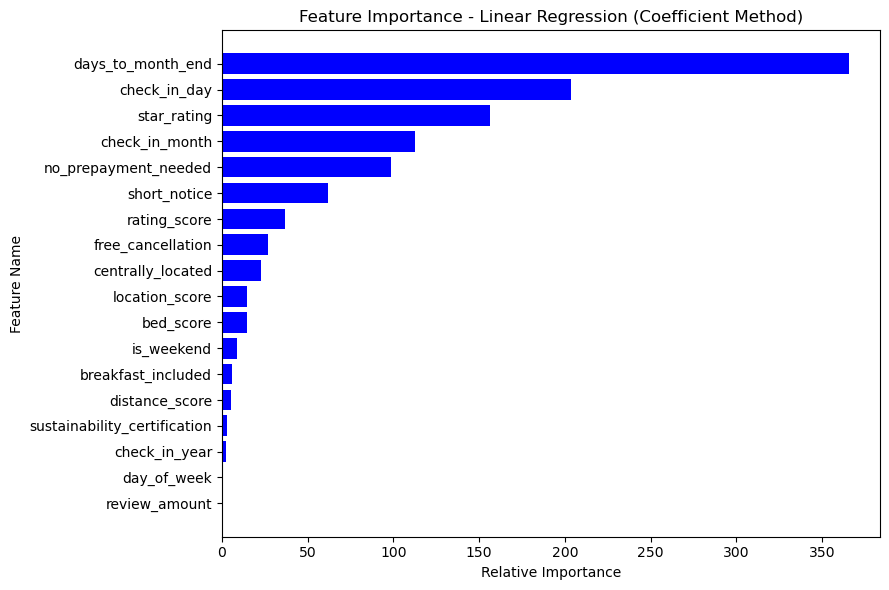


Linear Regression Feature Importance:
                         Feature  Importance
0              days_to_month_end  365.476814
1                   check_in_day  203.409238
2                    star_rating  156.368410
3                 check_in_month  112.425675
4           no_prepayment_needed   98.539444
5                   short_notice   61.663335
6                   rating_score   36.521511
7              free_cancellation   26.675591
8              centrally_located   22.996855
9                 location_score   14.712406
10                     bed_score   14.577106
11                    is_weekend    8.936803
12            breakfast_included    5.984004
13                distance_score    5.329449
14  sustainability_certification    3.000084
15                 check_in_year    2.339725
16                   day_of_week    0.099505
17                 review_amount    0.018510


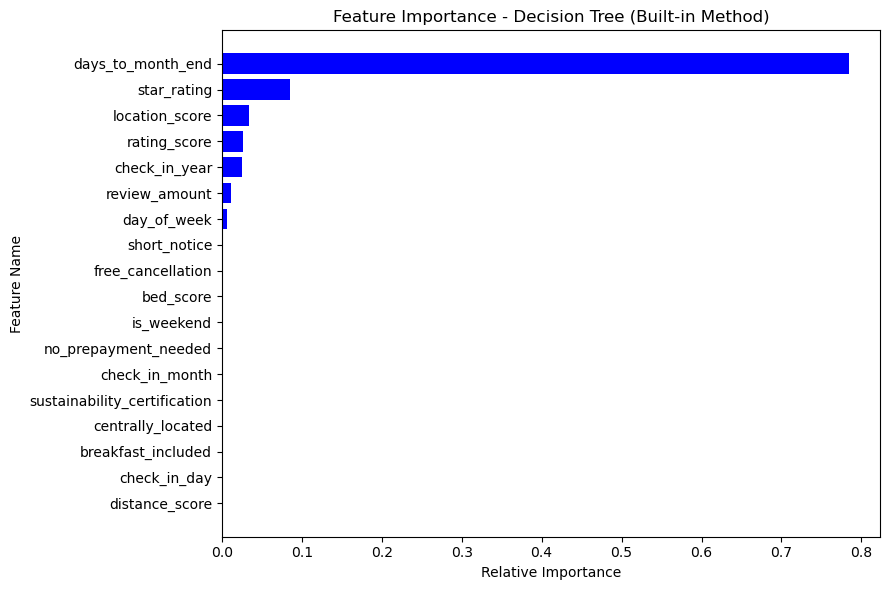


Decision Tree Feature Importance (Built-in Method):
                         Feature  Importance
0                 distance_score    0.000000
1                   check_in_day    0.000000
2             breakfast_included    0.000000
3              centrally_located    0.000000
4   sustainability_certification    0.000000
5                 check_in_month    0.000000
6           no_prepayment_needed    0.000017
7                     is_weekend    0.000761
8                      bed_score    0.000914
9              free_cancellation    0.001353
10                  short_notice    0.001994
11                   day_of_week    0.006954
12                 review_amount    0.011091
13                 check_in_year    0.024715
14                  rating_score    0.026067
15                location_score    0.033301
16                   star_rating    0.085244
17             days_to_month_end    0.784025


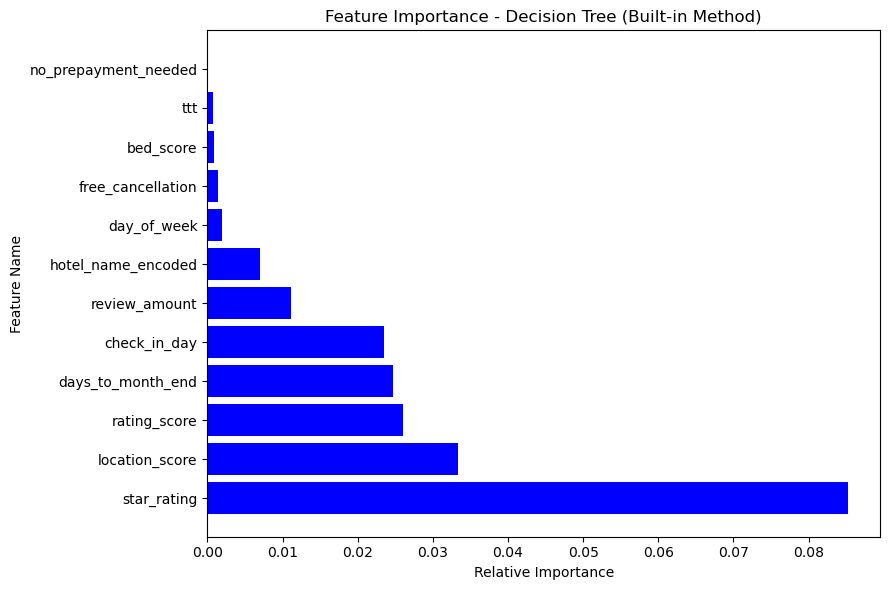


Decision Tree Feature Importance (Built-in Method):
                 Feature  Importance
0            star_rating    0.085244
1         location_score    0.033301
2           rating_score    0.026067
3      days_to_month_end    0.024715
4           check_in_day    0.023563
5          review_amount    0.011091
6     hotel_name_encoded    0.006954
7            day_of_week    0.001994
8      free_cancellation    0.001353
9              bed_score    0.000914
10                   ttt    0.000761
11  no_prepayment_needed    0.000017


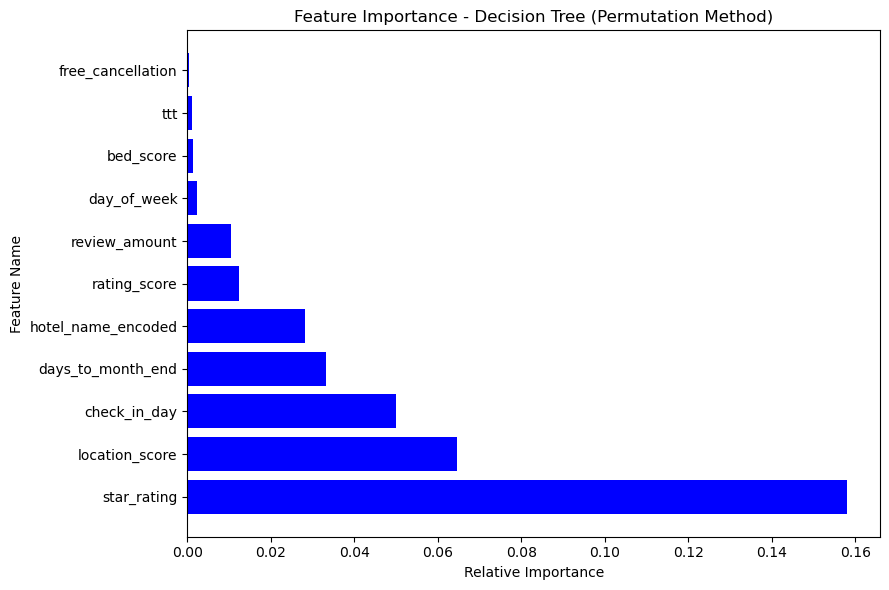


Decision Tree Feature Importance (Permutation Method):
               Feature  Importance
0          star_rating    0.157995
1       location_score    0.064569
2         check_in_day    0.050035
3    days_to_month_end    0.033231
4   hotel_name_encoded    0.028137
5         rating_score    0.012477
6        review_amount    0.010410
7          day_of_week    0.002298
8            bed_score    0.001296
9                  ttt    0.001164
10   free_cancellation    0.000320


In [10]:
# Feature Importance
exclude_cols = ['price', 'snapshot', 'checkin', 'checkout', 'ttt', 'los', 'hotel_name_encoded', 'group_index','hotel_name']  
feature_cols = [col for col in df.columns if col not in exclude_cols]  # שמות הפיצ'רים בפועל

# feature_cols = X.columns
feature_names = np.array(feature_cols)

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_importances = np.abs(lr.coef_)

lr_indices = np.argsort(lr_importances)[::-1]

valid_indices = [i for i in lr_indices if i < len(feature_names)]
valid_feature_names = feature_names[valid_indices]  
valid_lr_importances = lr_importances[valid_indices]  

plt.figure(figsize=(9, 6))
plt.title("Feature Importance - Linear Regression (Coefficient Method)")
plt.barh(valid_feature_names, valid_lr_importances, color="blue", align="center")
plt.xlabel("Relative Importance")
plt.ylabel("Feature Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

lr_importance_df = pd.DataFrame({
    "Feature": valid_feature_names, 
    "Importance": valid_lr_importances
})

print("\nLinear Regression Feature Importance:")
print(lr_importance_df)

# 2. Decision Tree Feature Importance - Built-in Method (Algorithm-Specific)

dt = DecisionTreeRegressor(max_depth=6, min_samples_split=5, random_state=42)
dt.fit(X_train, y_train)

dt_importances = dt.feature_importances_

feature_names = np.array(feature_cols)  
dt_indices = np.argsort(dt_importances)[::-1]  

valid_indices = [i for i in dt_indices if i < len(feature_names)]
valid_feature_names = feature_names[valid_indices]  
valid_dt_importances = dt_importances[valid_indices]  

valid_feature_names = valid_feature_names[::-1]
valid_dt_importances = valid_dt_importances[::-1]

plt.figure(figsize=(9, 6))
plt.title("Feature Importance - Decision Tree (Built-in Method)")
plt.barh(valid_feature_names, valid_dt_importances, color="blue", align="center")
plt.xlabel("Relative Importance")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# feature importance table
dt_importance_df = pd.DataFrame({
    "Feature": valid_feature_names, 
    "Importance": valid_dt_importances
})

print("\nDecision Tree Feature Importance (Built-in Method):")
print(dt_importance_df)

# ### 3. Linear Regression - Permutation Importance (Black-box Method)

# Create scaler for Linear Regression permutation importance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression on scaled data
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

# Calculate permutation importance
# Use a subset of data for faster computation
sample_indices = np.random.choice(len(X_test_scaled), min(1000, len(X_test_scaled)), replace=False)
X_sample = X_test_scaled[sample_indices]
y_sample = y_test.iloc[sample_indices]

# 4. Decision Tree - Permutation Importance (Black-box Method)

# Decision Tree model
dt = DecisionTreeRegressor(max_depth=6, min_samples_split=5, random_state=42)
dt.fit(X_train, y_train)

# Calculate permutation importance
dt_importances = dt.feature_importances_

# make sure feature names are in sync with indices
actual_feature_names = np.array(X_train.columns)  

# sort indices by importance
valid_dt_indices = np.where(dt_importances > 0)[0]  
valid_dt_indices = [i for i in valid_dt_indices if i < len(actual_feature_names)]  # ווידוא אינדקסים חוקיים

valid_dt_importances = dt_importances[valid_dt_indices]  
valid_dt_feature_names = actual_feature_names[valid_dt_indices]  

# loss removal if exists
mask = valid_dt_feature_names != "los"
valid_dt_feature_names = valid_dt_feature_names[mask]
valid_dt_importances = valid_dt_importances[mask]


sorted_dt_indices = np.argsort(valid_dt_importances)[::-1]
valid_dt_importances = valid_dt_importances[sorted_dt_indices]
valid_dt_feature_names = valid_dt_feature_names[sorted_dt_indices]

# plot the graph
plt.figure(figsize=(9, 6))
plt.title("Feature Importance - Decision Tree (Built-in Method)")
plt.barh(valid_dt_feature_names, valid_dt_importances, color="blue", align="center")
plt.xlabel("Relative Importance")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


dt_importance_df = pd.DataFrame({
    "Feature": valid_dt_feature_names, 
    "Importance": valid_dt_importances
})

print("\nDecision Tree Feature Importance (Built-in Method):")
print(dt_importance_df)


try:
    dt_perm = permutation_importance(
        dt, X_test, y_test, 
        n_repeats=5, random_state=42, n_jobs=-1
    )

    perm_importances = dt_perm.importances_mean
    valid_perm_indices = np.where(perm_importances > 0)[0]  
    valid_perm_importances = perm_importances[valid_perm_indices]

    valid_feature_names = np.array(X_test.columns)[valid_perm_indices]

    mask = valid_feature_names != "los"
    valid_feature_names = valid_feature_names[mask]
    valid_perm_importances = valid_perm_importances[mask]

    sorted_indices = np.argsort(valid_perm_importances)[::-1]
    valid_perm_importances = valid_perm_importances[sorted_indices]
    valid_feature_names = valid_feature_names[sorted_indices]

    plt.figure(figsize=(9, 6))
    plt.title("Feature Importance - Decision Tree (Permutation Method)")
    plt.barh(valid_feature_names, valid_perm_importances, color="blue", align="center")
    plt.xlabel("Relative Importance")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

    dt_perm_df = pd.DataFrame({
        "Feature": valid_feature_names, 
        "Importance": valid_perm_importances
    })
    print("\nDecision Tree Feature Importance (Permutation Method):")
    print(dt_perm_df)

except Exception as e:
    print(f"Error calculating permutation importance: {e}")

# Neural Network Regressor with MLP Architecture

This section implements a simple Multi-Layer Perceptron (MLP) neural network for predicting hotel prices. The architecture consists of:
- 64-node input layer with ReLU activation
- 32-node hidden layer with ReLU activation
- 16-node hidden layer with ReLU activation
- Single-node output layer (for price prediction)
- Dropout layers (0.2 and 0.1) to prevent overfitting

The model is trained with early stopping to find the optimal training duration.


--- Neural Network: Simple MLP Architecture ---
Epoch 1/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 998526.3750 - val_loss: 140968.4219
Epoch 2/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 166002.5469 - val_loss: 136884.1250
Epoch 3/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 171724.2656 - val_loss: 132384.2969
Epoch 4/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 147554.7656 - val_loss: 130953.5391
Epoch 5/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 149569.0938 - val_loss: 129466.5156
Epoch 6/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 140090.9531 - val_loss: 128986.4453
Epoch 7/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 153684.2188 - val_loss: 125523.8438
Epoch 8/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 157809.4844 - val_loss: 125460.4688
Epoch 9/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 147117.7969 - val_loss: 124926.2812
Epoch 10/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 137497.9062 - va

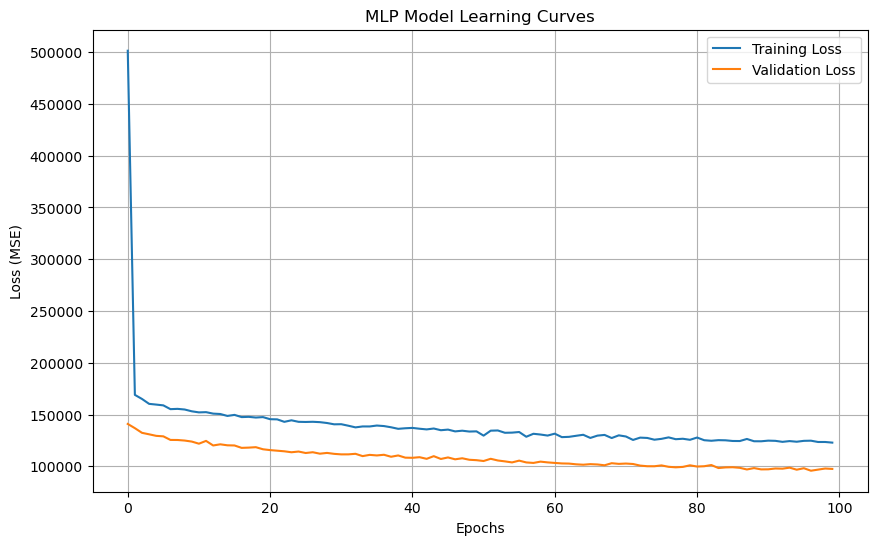

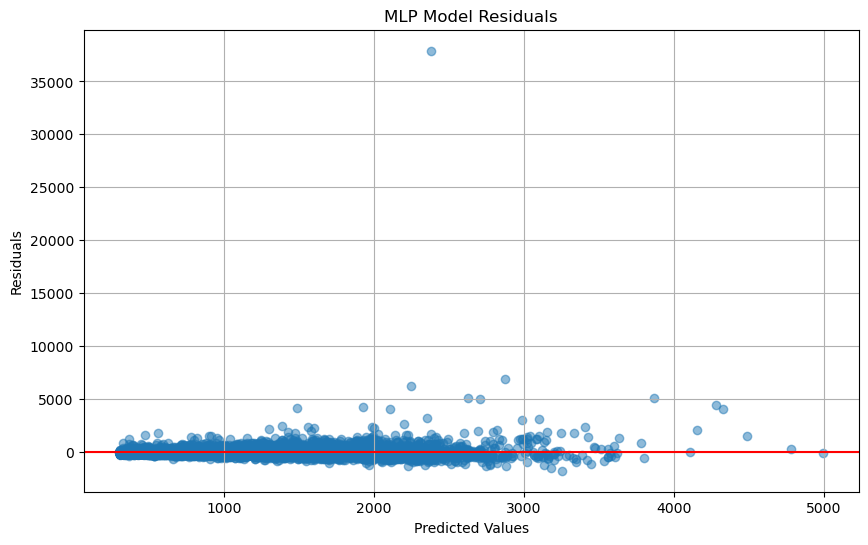

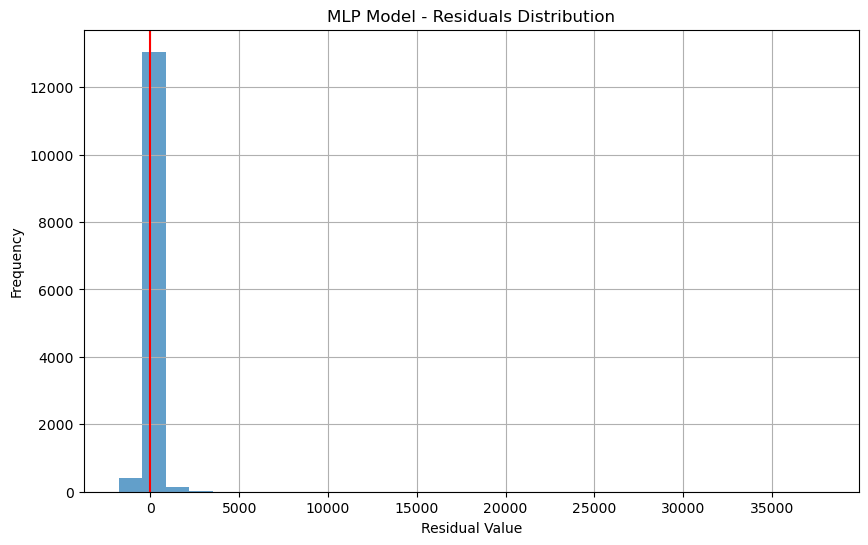

In [11]:
# Architecture 1: Simple MLP
def create_mlp_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train and evaluate MLP model
print("\n--- Neural Network: Simple MLP Architecture ---")
mlp_model = create_mlp_model(X_train_std.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mlp_history = mlp_model.fit(
    X_train_std, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Predict and evaluate
y_train_pred_mlp = mlp_model.predict(X_train_std).flatten()
y_test_pred_mlp = mlp_model.predict(X_test_std).flatten()

# Calculate metrics
train_mse_mlp = mean_squared_error(y_train, y_train_pred_mlp)
test_mse_mlp = mean_squared_error(y_test, y_test_pred_mlp)
train_rmse_mlp = np.sqrt(train_mse_mlp)
test_rmse_mlp = np.sqrt(test_mse_mlp)
train_mae_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
test_mae_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
train_r2_mlp = r2_score(y_train, y_train_pred_mlp)
test_r2_mlp = r2_score(y_test, y_test_pred_mlp)

print("\nMLP Neural Network Performance:")
print(f"Train MSE: {train_mse_mlp:.2f}, Test MSE: {test_mse_mlp:.2f}")
print(f"Train RMSE: {train_rmse_mlp:.2f}, Test RMSE: {test_rmse_mlp:.2f}")
print(f"Train MAE: {train_mae_mlp:.2f}, Test MAE: {test_mae_mlp:.2f}")
print(f"Train R²: {train_r2_mlp:.4f}, Test R²: {test_r2_mlp:.4f}")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot MLP residuals
plt.figure(figsize=(10, 6))
residuals_mlp = y_test - y_test_pred_mlp
plt.scatter(y_test_pred_mlp, residuals_mlp, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('MLP Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot residual distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_mlp, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('MLP Model - Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Advanced Neural Network with Hotel Embedding Architecture

This section implements a more sophisticated neural network that uses embedding to handle categorical data (hotel names). The architecture includes:
- Separate input paths for numeric features and hotel identifiers
- Embedding layer to convert hotel IDs into learnable vectors
- Feature fusion through concatenation
- Multi-layer network with mixed activation functions (tanh, sigmoid, and ReLU)
- Dropout layers for regularization

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 10)     │      4,100 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        672 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 42)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      2,752 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         17 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,149 (39.64 KB)

 Trainable params: 10,149 (39.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1588705.2500 - val_loss: 856658.3125
Epoch 2/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 694509.6250 - val_loss: 418264.4062
Epoch 3/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 303133.5312 - val_loss: 150814.1562
Epoch 4/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 145696.2656 - val_loss: 106223.2266
Epoch 5/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 145517.2969 - val_loss: 93388.2969
Epoch 6/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 94476.8984 - val_loss: 87304.8672
Epoch 7/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 110066.9844 - val_loss: 81416.3438
Epoch 8/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 84935.6250 - val_loss: 78372.7031
Epoch 9/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 88275.2031 - val_loss: 76790.3438
Epoch 10/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 86793.6172 - val_loss: 74586.4688
Epoch 11/100
795/795 ━━━━━━━━━━━━━━━━━

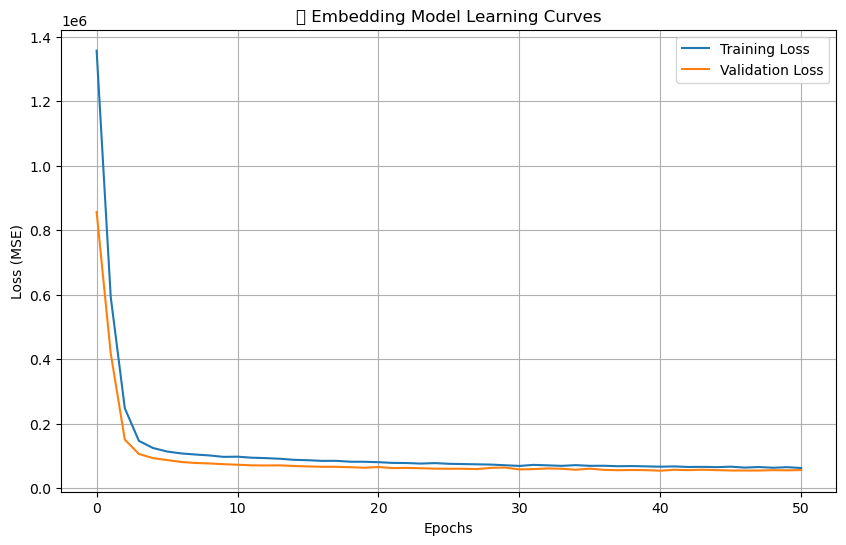

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

num_hotels = X_train["hotel_name_encoded"].max() + 1  

X_train_hotel_id = X_train["hotel_name_encoded"].values
X_test_hotel_id = X_test["hotel_name_encoded"].values

cols_to_drop = {"hotel_name", "hotel_name_encoded"} & set(X_train.columns)
X_train_numeric = X_train.drop(columns=cols_to_drop, errors="ignore").values
X_test_numeric = X_test.drop(columns=cols_to_drop, errors="ignore").values

scaler_emb = StandardScaler()
X_train_numeric_scaled = scaler_emb.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler_emb.transform(X_test_numeric)

def create_embedding_model(numeric_input_dim, num_hotels):
    numerical_input = Input(shape=(numeric_input_dim,))
    numeric_dense = Dense(32, activation='relu')(numerical_input)
    
    hotel_input = Input(shape=(1,))
    hotel_embedding = Embedding(input_dim=num_hotels, output_dim=10, input_length=1)(hotel_input)  
    hotel_flatten = Flatten()(hotel_embedding)
    
    combined = Concatenate()([numeric_dense, hotel_flatten])
    
    x = Dense(64, activation='tanh')(combined)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(1)(x)
    
    model = Model(inputs=[numerical_input, hotel_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

embedding_model = create_embedding_model(X_train_numeric_scaled.shape[1], num_hotels)

embedding_model.summary()

early_stopping_emb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

emb_history = embedding_model.fit(
    [X_train_numeric_scaled, X_train_hotel_id.reshape(-1, 1)], 
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_emb],
    verbose=1
)

y_train_pred_emb = embedding_model.predict([X_train_numeric_scaled, X_train_hotel_id.reshape(-1, 1)]).flatten()
y_test_pred_emb = embedding_model.predict([X_test_numeric_scaled, X_test_hotel_id.reshape(-1, 1)]).flatten()

train_mse_emb = mean_squared_error(y_train, y_train_pred_emb)
test_mse_emb = mean_squared_error(y_test, y_test_pred_emb)
train_rmse_emb = np.sqrt(train_mse_emb)
test_rmse_emb = np.sqrt(test_mse_emb)
train_mae_emb = mean_absolute_error(y_train, y_train_pred_emb)
test_mae_emb = mean_absolute_error(y_test, y_test_pred_emb)
train_r2_emb = r2_score(y_train, y_train_pred_emb)
test_r2_emb = r2_score(y_test, y_test_pred_emb)

print("\n📊 **Embedding:**")
print(f"Train MSE: {train_mse_emb:.2f}, Test MSE: {test_mse_emb:.2f}")
print(f"Train RMSE: {train_rmse_emb:.2f}, Test RMSE: {test_rmse_emb:.2f}")
print(f"Train MAE: {train_mae_emb:.2f}, Test MAE: {test_mae_emb:.2f}")
print(f"Train R²: {train_r2_emb:.4f}, Test R²: {test_r2_emb:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(emb_history.history['loss'], label='Training Loss')
plt.plot(emb_history.history['val_loss'], label='Validation Loss')
plt.title('📊 Embedding Model Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# Testing best model with different split

TTT-Based Split:
Train set (TTT >= 25): 13300 samples (29.3%)
Test set (TTT < 25): 32100 samples (70.7%)

TTT-based training set size: (13300, 23)
TTT-based test set size: (32100, 23)


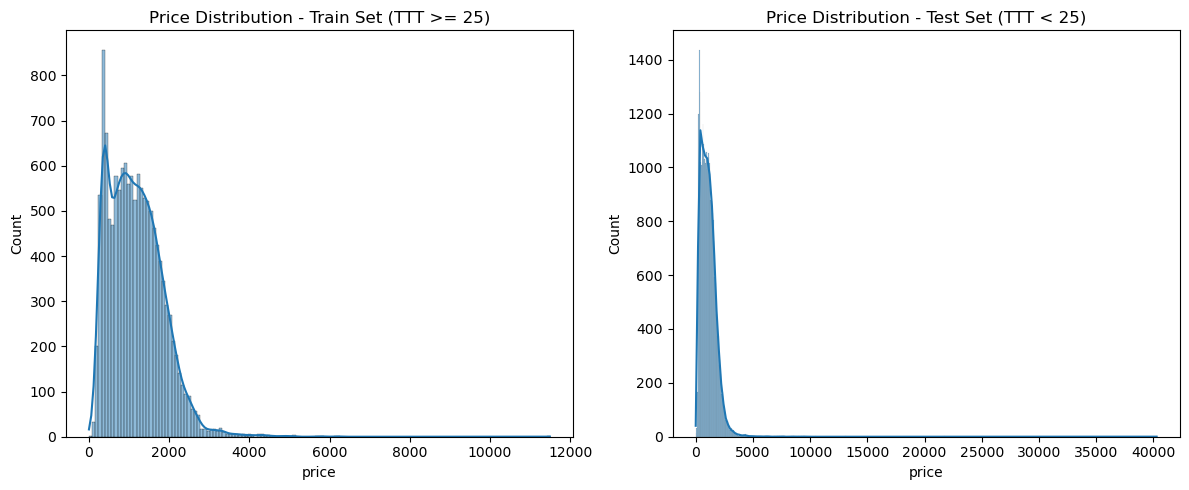


--- Gaussian Regressor with TTT-based split ---

GaussianProcessRegressor Performance with TTT-based split:
Train set (TTT >= 25) MSE: 6845.01, Test set (TTT < 25) MSE: 436114.36
Train set (TTT >= 25) RMSE: 82.73, Test set (TTT < 25) RMSE: 660.39
Train set (TTT >= 25) MAE: 65.15, Test set (TTT < 25) MAE: 509.99
Train set (TTT >= 25) R²: 0.9858, Test set (TTT < 25) R²: -0.0152


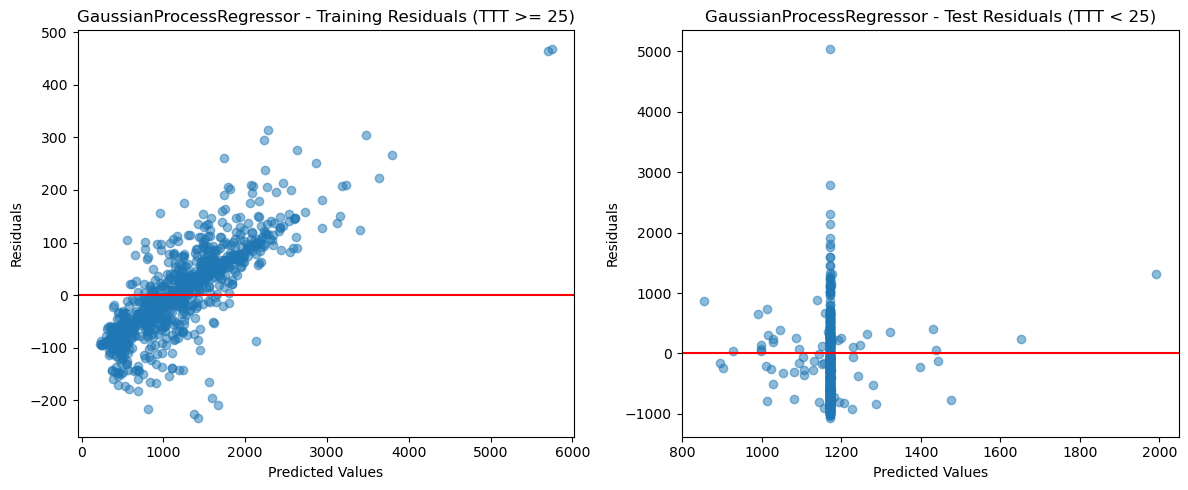

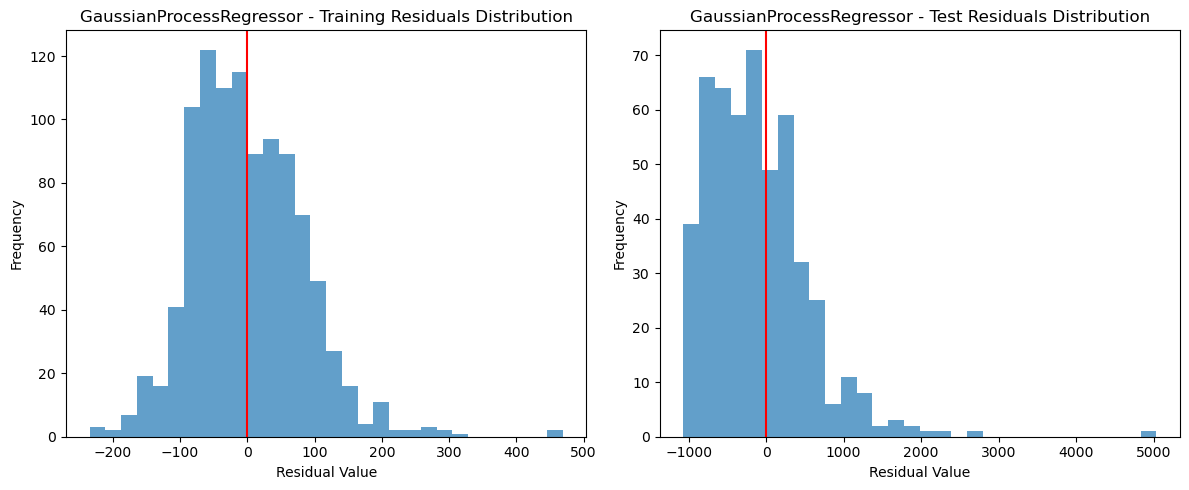

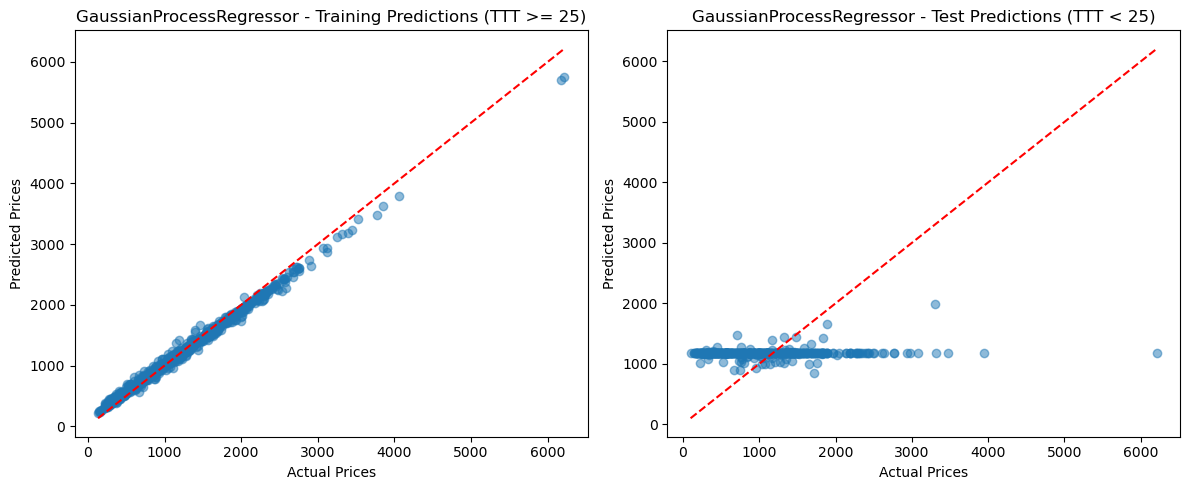


--- Summary: Gaussian Regressor with TTT-based Split ---
Test R²: -0.0152
Test RMSE: 660.39
Test MAE: 509.99


In [13]:
# Time-Based Train-Test Split for Gradient Boosting
# Train: TTT >= 25 days, Test: TTT < 25 days

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Function to evaluate model with TTT-based split
def evaluate_model_ttt_split(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train and predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n{model_name} Performance with TTT-based split:")
    print(f"Train set (TTT >= 25) MSE: {train_mse:.2f}, Test set (TTT < 25) MSE: {test_mse:.2f}")
    print(f"Train set (TTT >= 25) RMSE: {train_rmse:.2f}, Test set (TTT < 25) RMSE: {test_rmse:.2f}")
    print(f"Train set (TTT >= 25) MAE: {train_mae:.2f}, Test set (TTT < 25) MAE: {test_mae:.2f}")
    print(f"Train set (TTT >= 25) R²: {train_r2:.4f}, Test set (TTT < 25) R²: {test_r2:.4f}")
    
    # Plot residuals
    plt.figure(figsize=(12, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    residuals_train = y_train - y_train_pred
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Training Residuals (TTT >= 25)')
    
    # Test residuals
    plt.subplot(1, 2, 2)
    residuals_test = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Test Residuals (TTT < 25)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Training Residuals Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Test Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 5))
    
    # Training data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name} - Training Predictions (TTT >= 25)')
    
    # Test data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name} - Test Predictions (TTT < 25)')
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }

# Time-Based Train-Test Split for Gaussian Regressor
# Create TTT-based split
# Train: TTT >= 25, Test: TTT < 25
mask_train = df['ttt'] >= 25
mask_test = df['ttt'] < 25

# Check the size of each split
train_size = sum(mask_train)
test_size = sum(mask_test)
print(f"TTT-Based Split:")
print(f"Train set (TTT >= 25): {train_size} samples ({100*train_size/len(df):.1f}%)")
print(f"Test set (TTT < 25): {test_size} samples ({100*test_size/len(df):.1f}%)")

# Create feature and target for the new split
X = df.drop(['price', 'snapshot', 'checkin', 'checkout'], axis=1)
y = df['price']

# Convert any remaining object columns to numeric if needed
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    
# Fill any NaN values created by conversion
X = X.fillna(-1)

# Create the split
X_train_ttt = X[mask_train]
X_test_ttt = X[mask_test]
y_train_ttt = y[mask_train]
y_test_ttt = y[mask_test]

print(f"\nTTT-based training set size: {X_train_ttt.shape}")
print(f"TTT-based test set size: {X_test_ttt.shape}")

# Analyze distribution of prices in both sets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_train_ttt, kde=True)
plt.title('Price Distribution - Train Set (TTT >= 25)')
plt.xlabel('price')

plt.subplot(1, 2, 2)
sns.histplot(y_test_ttt, kde=True)
plt.title('Price Distribution - Test Set (TTT < 25)')
plt.xlabel('price')

plt.tight_layout()
plt.show()

# Sample the data to reduce computational complexity for Gaussian Process Regressor
np.random.seed(42)
sample_size_train = min(1000, len(X_train_ttt))
sample_size_test = min(500, len(X_test_ttt))

train_indices = np.random.choice(len(X_train_ttt), sample_size_train, replace=False)
test_indices = np.random.choice(len(X_test_ttt), sample_size_test, replace=False)

X_train_ttt_sample = X_train_ttt.iloc[train_indices]
y_train_ttt_sample = y_train_ttt.iloc[train_indices]
X_test_ttt_sample = X_test_ttt.iloc[test_indices]
y_test_ttt_sample = y_test_ttt.iloc[test_indices]

# Train Gaussian Regressor with TTT-based split
print("\n--- Gaussian Regressor with TTT-based split ---")
gpr_model_ttt = GaussianProcessRegressor(
        kernel=(RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)), 
        n_restarts_optimizer=1, 
        normalize_y=True,  
        random_state=42
    )
gb_results_ttt = evaluate_model_ttt_split(gpr_model_ttt, X_train_ttt_sample, X_test_ttt_sample, 
                                         y_train_ttt_sample, y_test_ttt_sample, 
                                         "GaussianProcessRegressor")

# Print summary of results
print("\n--- Summary: Gaussian Regressor with TTT-based Split ---")
print(f"Test R²: {gb_results_ttt['test_r2']:.4f}")
print(f"Test RMSE: {gb_results_ttt['test_rmse']:.2f}")
print(f"Test MAE: {gb_results_ttt['test_mae']:.2f}")

Based on the results of our time-based split experiment with Gaussian regressor with rbf, whitekernel , we can see a significant difference in model performance when predicting "future" prices. While the model showed excellent performance on the training data (TTT ≥ 25 days), its predictive power dropped substantially when forecasting prices for bookings closer to check-in (TTT < 25 days).
The model computing time forced us to set sample of the data in order to test it, what maybe preventing us from seeing better results.

These findings suggest that hotel pricing dynamics change significantly as the check-in date approaches, creating challenges for models trained on earlier booking windows. For practical applications, this indicates that separate models or additional time-based features may be necessary to accurately predict how prices evolve throughout the booking timeline.